In [1]:
# Imports functions into the program
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Imported for categorization of the Sources
from scipy import stats
import astropy.stats as ast
from astropy.visualization import hist
import urllib.request
import lmfit
from importlib import reload

# Import from BB analysis github
import LC
from LC_Set import LC_Set
from fermi_catalog import select_bll, select_fsrq, select_bcu

from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from scipy.interpolate import SmoothBivariateSpline
import astropy.units as u

# COSI Analysis

## Weekly

### Flare Detection

In [2]:
# Using the new 2025 dataset. The new dataset has renamed ts2 to return_code2, so the code has been updated accordingly.
table = "new_db_Aug2025.csv"

opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'weekly'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
display(pd.DataFrame(cadence_df))
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

,Unnamed: 0,source_name,cadence,tmin,tmax,photon_flux2,photon_flux_error2,photon_index2,return_code2,ts2
3050,3050,4FGL J0001.2-0747,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.51
3051,3051,4FGL J0001.5+2113,weekly,239587201,240192001,1.480000e-08,1.550000e-08,2.12,0.0,1.47
3052,3052,4FGL J0003.3-1928,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.25
3053,3053,4FGL J0004.3+4614,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.31
3054,3054,4FGL J0004.4-4737,weekly,239587201,240192001,5.030000e-08,3.010000e-08,3.15,0.0,5.02
...,...,...,...,...,...,...,...,...,...,...
4817470,4817470,4FGL J2358.0-4601,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4817471,4817471,4FGL J2358.3-1021,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4817472,4817472,4FGL J2358.3+3830,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4817473,4817473,4FGL J2359.0+3922,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00


In [3]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400
COSI_bkg_rate = 0.1
import copy

def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = copy.deepcopy(sourcelightcurve)
    
    if not hasattr(sourcelightcurve, "hops"):
        sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)


    if sourcelightcurve.hops is None:
        quiescent_background,qui_err = np.nan, np.nan
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')

        

    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.rcParams['hatch.color'] = 'black'
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=-(np.max(sourcelightcurve.flux)*0.02),y2=0,color='y',alpha=0.5,label='OLD Rocking',edgecolor='black')
    plt.fill_between([GC_START,GC_STOP],y1=-(np.max(sourcelightcurve.flux)*0.02),y2=0,color='y',alpha=0.5,label='GC POINTING', hatch = '/',edgecolor='black')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=-(np.max(sourcelightcurve.flux)*0.02),y2=0,color='y',alpha=0.5,label='SOLAR PANEL ANOMALY', hatch = '///',edgecolor='black')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    flarestack=[0,0,0,0,0,0,0,0,0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)] # array of flux ph/cm2/s
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400 # ph/cm2/s * days * s/day = ph/cm2
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        starttime_MJD= hops_bl[i].start_time
        starttime_s = starttime_MJD * 86400
        observation_time = (np.max(sourcelightcurve.time)-np.min(sourcelightcurve.time))*86400
        portion_of_obs = duration/observation_time
        integral = np.sum(temp_sum) # sum of flux over duration ph/cm2 for the flare
        background_counts = COSI_bkg_rate * duration
        fluxsum = np.sum(temp) # sum of flux ph/cm2/s over duration
        flare_asym = hops_bl[i].asym
        if len(fsrq_names[fsrq_names==sourcelightcurve.name])>0:
            blazartype='FSRQ'
        elif len(bll_names[bll_names==sourcelightcurve.name])>0:
            blazartype='BLL'
        elif len(bcu_names[bcu_names==sourcelightcurve.name])>0:
            blazartype='BCU'
        else:
            blazartype='None'
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype,flare_asym]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype,flare_asym]))
    return flarestack

def hop_characterizer(hops, COSI_bkg_rate, COSI_Aeff, LAT_Aeff, ph_ratio, int_flux_ratio):
    # Given a hop_bl object (object that contains data about each flare), returns an array of characteristics for that each flare.

    # Empty arrays that will store the characteristics of each flare.
    hop_durations = []
    hop_sourcecounts = []
    hop_asymmetries = []
    hop_coverages = []
    hop_background = []
    hop_sourcecounts = []
    hop_MDP99 = []
    hop_name = []
    blazartype = []
    hop_fluences = []
    hop_avg_fluxes = []
    hop_start_times = []
    entire_avg_flux = []
    hop_peak_fluxes = []

    # Loop through each hop and extract its characteristics.
    for hop in hops:
        
        
        # Since duration is in days (MJD), convert to seconds.
        duration = hop.dur * 86400

        # add all flux values, then multiply by Effective Area of Fermi and the conversion factor. Divide by Area of COSI to get counts in COSI band.
        
        # Asymmetry of the flare. This is tacked on just in case we want to use it later.
        asymmetry = hop.asym

        # Portion of time the flare is active.
        coverage = ((hop.dur) / (sourcelightcurve.time[-1] - sourcelightcurve.time[0]))

        # Background counts during the flare duration.
        background_counts = duration * COSI_bkg_rate 

        COSI_ph_rate = np.mean(hop.flux)  * LAT_Aeff * ph_ratio

        # Total fluence during the flare.
        fluence_LAT = np.mean(hop.flux) * duration

        fluence_COSI = np.mean(hop.flux) * int_flux_ratio * duration

        # Average flux of the flare.
        avg_flux = np.mean(hop.flux) * int_flux_ratio
        lc_avg_flux = np.mean(sourcelightcurve.flux) * int_flux_ratio
        peak_flux = np.max(hop.flux) * int_flux_ratio

        # Average flux values, then multiply by Effective Area of Fermi and the conversion factor.
        sourcecounts = COSI_ph_rate * duration

        start_time = hop.start_time

        # Append characteristics to their respective arrays.
        hop_name.append(hop.name)
        hop_durations.append(duration)
        hop_sourcecounts.append(sourcecounts)
        hop_asymmetries.append(asymmetry)
        hop_coverages.append(coverage)
        hop_background.append(background_counts)
        hop_MDP99.append(ComputeMDP99(sourcecounts, background_counts))
        hop_fluences.append(fluence_COSI)
        hop_avg_fluxes.append(avg_flux)
        hop_peak_fluxes.append(peak_flux)
        hop_start_times.append(start_time)
        entire_avg_flux.append(lc_avg_flux)

        if len(fsrq_names[fsrq_names==sourcelightcurve.name])>0:
            blazartype.append('FSRQ')
        elif len(bll_names[bll_names==sourcelightcurve.name])>0:
            blazartype.append('BLL')
        elif len(bcu_names[bcu_names==sourcelightcurve.name])>0:
            blazartype.append('BCU')
        else:
            blazartype.append('None')
            
    # Return all characteristics
    return hop_name, hop_durations, hop_sourcecounts, hop_asymmetries, hop_coverages, hop_background, hop_MDP99, blazartype, hop_fluences, hop_avg_fluxes, hop_start_times, entire_avg_flux, hop_peak_fluxes

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = (4.29 / (average_mu*(src_counts))) * np.sqrt(src_counts+bkg_counts) * 100
    
    return mdp99

ignorelist = ['4FGL J0010.6+2043','4FGL J0222.0-1616','4FGL J0228.0-3026','4FGL J0312.8+0134',
'4FGL J0358.9+6004','4FGL J0824.7+5552','4FGL J1031.6+6019','4FGL J1209.8+1810','4FGL J1446.7+1719','4FGL J1635.6+3628',
'4FGL J1647.5+4950','4FGL J1716.1+6836','4FGL J1724.9+7654','4FGL J1808.1-5013','4FGL J2256.0-2740','4FGL J1222.5+0414',
'4FGL J0405.6-1308','4FGL J0336.4+3224','4FGL J1337.6-1257','4FGL J1924.8-2914','4FGL J0024.7+0349','4FGL J0239.7+0415',
'4FGL J0904.6+5200','4FGL J1118.2-0415','4FGL J1205.7-2635','4FGL J1324.9+4748','4FGL J1445.9-1626','4FGL J1559.9+2319',
'4FGL J1650.3-5045','4FGL J0116.0-1136','4FGL J0200.6-6637','4FGL J0224.9+1843','4FGL J0304.5+3349','4FGL J0347.7-3616',
'4FGL J0427.3-3900','4FGL J0450.3-4419','4FGL J0617.6-4028','4FGL J0746.4+2546','4FGL J0805.4+6147','4FGL J0943.7+6137',
'4FGL J1043.2+2408','4FGL J1200.7+2008','4FGL J1659.7-3131','4FGL J1747.6-5308','4FGL J1824.5+0107','4FGL J1912.1-0803',
'4FGL J2040.5-1705','4FGL J2120.6-1254','4FGL J2148.6+0652','4FGL J2149.7+1917','4FGL J2207.6+0053','4FGL J2358.0-4601',
'4FGL J0034.0-4116','4FGL J0035.8+6131','4FGL J0137.9+5814','4FGL J0152.2+3714','4FGL J0156.5+3914','4FGL J0342.2+3858', 
'4FGL J0353.0+5654','4FGL J0401.7+2112','4FGL J0407.5+0741','4FGL J0453.3+2843','4FGL J0455.7-4617','4FGL J0512.8+4041',
'4FGL J0635.6-7518','4FGL J0638.7+5658','4FGL J0647.7-6058','4FGL J0713.0+5738','4FGL J0723.5+2900','4FGL J0747.3-3310',
'4FGL J0806.5+4503','4FGL J0836.5-2026','4FGL J0911.0-5047','4FGL J0923.5+3852','4FGL J1001.1+2911','4FGL J1015.6+5553',
'4FGL J1016.0+0512','4FGL J1018.1+1905','4FGL J1045.8-2928','4FGL J1136.2+3407','4FGL J1158.5+4824','4FGL J1225.6-7313',
'4FGL J1238.5-1201','4FGL J1322.2+0842','4FGL J1440.0-1530','4FGL J1454.4-3744','4FGL J1513.4-3231','4FGL J1516.9+1934',
'4FGL J1656.0+2047','4FGL J1753.6-5014','4FGL J1808.2+3500','4FGL J1834.7-5858','4FGL J1912.0+1612','4FGL J1917.7-6930', 
'4FGL J1942.1+4011','4FGL J2130.4-4241','4FGL J2143.1-3929','4FGL J2146.4-1528','4FGL J2219.2-0342','4FGL J2359.2-3134', 
'4FGL J0059.4-5654','4FGL J0132.1-0956','4FGL J0156.3-2420','4FGL J0205.7+6449','4FGL J0240.5+6113','4FGL J0259.0+0552',
'4FGL J0308.4+0407','4FGL J0333.0-3044','4FGL J0405.4-6929','4FGL J0448.7-2116','4FGL J0521.2+1637','4FGL J0534.5+2200',
'4FGL J0537.5+0959','4FGL J0540.0-7552','4FGL J0622.9+3326','4FGL J0833.3-4342c','4FGL J0850.0+5108','4FGL J0931.9+6737',
'4FGL J0948.9+0022','4FGL J1023.7+0038','4FGL J1045.1-5940','4FGL J1047.2+6740','4FGL J1106.7+3623','4FGL J1228.0-4853',
'4FGL J1230.8+1223','4FGL J1231.1-1412','4FGL J1401.7-3217','4FGL J1418.4+3543','4FGL J1505.0+0326','4FGL J1514.8+4448',
'4FGL J1535.9+3743','4FGL J1543.6+0452','4FGL J1626.5-4406','4FGL J1644.9+2620','4FGL J1732.7-5050','4FGL J1753.9+2443',
'4FGL J1839.4-0553','4FGL J1935.2+2029','4FGL J2007.9-4432','4FGL J2021.5+4026','4FGL J2234.7+0943','4FGL J2237.6-5126',
'4FGL J0522.9-3628','4FGL J0433.0+0522','4FGL J0319.8+4130','4FGL J0324.8+3412','4FGL J1829.5+4845','4FGL J2055.0-5218',
'4FGL J1459.0+7140','4FGL J1632.8-1048','4FGL J1148.5+2629']

In [4]:
def maxwellian_function(x, N, a):
    mu = 2*a*(np.sqrt(2/np.pi))
    return N * (x**2*np.exp(-(x - mu)**2/(2*a**2)))/a**3

#background_ranges = [20,10,5,1,0.1]
percent_ranges = [0.3]
background_ranges = [1]
#percent_ranges = [0.3]
#table = 'COSICSV/COSI_factors_all_updated_only_logpar_flare_softer_+0.5_updated_60deg_offaxis_last.csv'
table = 'COSICSV/COSI_factors_all_updated_only_logpar_flare_updated_60deg_offaxis_last.csv'
for bkg in background_ranges:
    COSI_bkg_rate = bkg * 0.25
    for per in percent_ranges:
        percent = per
        quiescent_background_calc_array = [0,0,0,0]
        COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
        flare_array = []
        COSI_BAND_ALL = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0])
        fsrq_names = select_fsrq()['Source_Name']
        bll_names = select_bll()['Source_Name']
        bcu_names = select_bcu()['Source_Name']
        for i,s in COSI_LAT_Sources.iterrows():
            # Grabs the information from the table about each source.

            # Effective Area of Fermi LAT for the source.
            LAT_Aeff = COSI_LAT_Sources['Aeff_mean_LAT(cm2)'][i]

            # Effective Area of COSI for the source.
            COSI_Aeff = COSI_LAT_Sources['Aeff_mean_COSI(cm2)'][i]

            # Name of Source
            sourcename = COSI_LAT_Sources['Name'][i]
            if sourcename in ignorelist:
                print('source filtered out')
                continue
            if sourcename != '4FGL J1229.0+0202':
                continue
            # Conversion factor of counts between Fermi and COSI Bands. (0.1-100 GeV to 0.2-5 MeV)
            ph_ratio = COSI_LAT_Sources['ph/s_ratio'][i]

            #ph_ratio = 1

            # Conversion factor of flux between Fermi and COSI Bands. (0.1-100 GeV to 0.2-5 MeV)
            flux_ratio = COSI_LAT_Sources['Int_flux_ratio'][i]

            #flux_ratio = 1

            
            # Grabs data for the source from the cadence_df provided.
            sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
            titlestring = sourcename
            sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
            average_flux = np.nanmean(sourcearray['photon_flux2'])
            sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
            time = sourcearray['tmin']/SecsInDay + MJDREFI
            photon_flux = sourcearray['photon_flux2']
            errors = sourcearray['photon_flux_error2']

            if sourcename == '4FGL J1941.3-6210':
                    badtimes = [58309.00001157408,58526.00001157408,58680.00001157408,59051.00001157408,59422.00001157408]
                    mask = ~np.isin(time,badtimes)
                    time = time[mask]
                    photon_flux = photon_flux[mask]
                    errors = errors[mask]
            if sourcename == '4FGL J0805.4+6147':
                    badtimes = [59576.00001157408,59947.00001157408,60472.00001157408]
                    mask = ~np.isin(time,badtimes)
                    time = time[mask]
                    photon_flux = photon_flux[mask]
                    errors = errors[mask]
            if sourcename == '4FGL J1153.4+4931':
                    badtimes = [58785.00001157408]
                    mask = ~np.isin(time,badtimes)
                    time = time[mask]
                    photon_flux = photon_flux[mask]
                    errors = errors[mask]
            if sourcename == '4FGL J0116.0-1136':
                    badtimes = [58239.00001157408]
                    mask = ~np.isin(time,badtimes)
                    time = time[mask]
                    photon_flux = photon_flux[mask]
                    errors = errors[mask]
            if sourcename == '4FGL J0102.8+5824':
                    badtimes = [60227.00001157408]
                    mask = ~np.isin(time,badtimes)
                    time = time[mask]
                    photon_flux = photon_flux[mask]
                    errors = errors[mask]
            if sourcename == '4FGL J0359.6+5057':
                    badtimes = [58638.00001157408]
                    mask = ~np.isin(time,badtimes)
                    time = time[mask]
                    photon_flux = photon_flux[mask]
                    errors = errors[mask]
            if sourcename == '4FGL J0533.3+4823':
                    badtimes = [58260.00001157408,59002.00001157408,59744.00001157408]
                    mask = ~np.isin(time,badtimes)
                    time = time[mask]
                    photon_flux = photon_flux[mask]
                    errors = errors[mask]
            if sourcename == '4FGL J0533.3+4823':
                    badtimes = [58260.00001157408,59002.00001157408,59744.00001157408]
                    mask = ~np.isin(time,badtimes)
                    time = time[mask]
                    photon_flux = photon_flux[mask]
                    errors = errors[mask]
            if sourcename == '4FGL J0534.5+2201s':
                    badtimes = [59744.00001157408,60115.00001157408]
                    mask = ~np.isin(time,badtimes)
                    time = time[mask]
                    photon_flux = photon_flux[mask]
                    errors = errors[mask]
            if sourcename == '4FGL J0622.9+3326':
                    badtimes = [60479.00001157408]
                    mask = ~np.isin(time,badtimes)
                    time = time[mask]
                    photon_flux = photon_flux[mask]
                    errors = errors[mask]
            if sourcename == '4FGL J1535.8-4730':
                    badtimes = [58792.00001157408,59163.00001157408]
                    mask = ~np.isin(time,badtimes)
                    time = time[mask]
                    photon_flux = photon_flux[mask]
                    errors = errors[mask]
            if sourcename == '4FGL J1555.2-4149':
                    badtimes = [58421.00001157408,59163.00001157408]
                    mask = ~np.isin(time,badtimes)
                    time = time[mask]
                    photon_flux = photon_flux[mask]
                    errors = errors[mask]
            if sourcename == '4FGL J1941.3-6210':
                    badtimes = [59793.00001157408]
                    mask = ~np.isin(time,badtimes)
                    time = time[mask]
                    photon_flux = photon_flux[mask]
                    errors = errors[mask]
            # Creates the lightcurve object of the source.
            sourcelightcurve = LC.LightCurve(time,photon_flux,errors,name=titlestring)

            # Finding the initial flux threshold for detection.
            maxflux = np.max(photon_flux)
            minflux = np.min(photon_flux)
            delta_flux = maxflux - minflux
            delta_flux_percent = delta_flux * percent
            thresholdflux = minflux + delta_flux_percent


            # Initial flare detection.
            sourcelightcurve.get_bblocks(gamma_value=0.05)
            sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)

            quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward')

            if quiescent_background == np.nan:
                characterized_flares = [sourcename,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333]
                COSI_BAND = np.array(characterized_flares).T
                COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))
                quistack = np.array([sourcename,quiescent_background,qui_err,average_flux*flux_ratio]).T
                quiescent_background_calc_array = np.vstack((quiescent_background_calc_array,quistack))
                continue

            # Re-detecting flares with quiescent background.
            sourcelightcurve = LC.LightCurve(time,photon_flux,errors,name=titlestring)
            sourcelightcurve.get_bblocks(gamma_value=0.05)
            sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)

            hops_bl = sourcelightcurve.hops
            try:
                characterized_flares = hop_characterizer(hops_bl, COSI_bkg_rate=COSI_bkg_rate, COSI_Aeff=COSI_Aeff, LAT_Aeff=LAT_Aeff, ph_ratio=ph_ratio, int_flux_ratio=flux_ratio)
            except:
                characterized_flares = [sourcename,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333]
                COSI_BAND = np.array(characterized_flares).T
                COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))
                quistack = np.array([sourcename,quiescent_background,qui_err,average_flux*flux_ratio]).T
                quiescent_background_calc_array = np.vstack((quiescent_background_calc_array,quistack))
                continue

            # Stores flare attributes into final array.
            COSI_BAND = np.array(characterized_flares).T
            COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))
            quistack = np.array([sourcename,quiescent_background,qui_err,characterized_flares[-1][0]]).T
            quiescent_background_calc_array = np.vstack((quiescent_background_calc_array,quistack))

        #get rid of spaces in all headers with _

        COSI_BAND_BAT_weekly_df = pd.DataFrame(COSI_BAND_ALL)
        COSI_BAND_BAT_weekly_df.columns = ['Name','Duration_(s)', 'Source_Counts(ph)_(0.2-5_MeV)', 'Asymmetry', 'Coverage', 'Background_Counts', 'MDP99_(%)', 'Class', 'Photon_Fluence_(ph/cm2)_(0.2-5_MeV)', 'Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)','Start_Time_(MJD)','Average_Flux_of_Entire_Source_(0.2-5_MeV)', 'Peak_Flare_Flux_(0.2-5_MeV)']
        COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Source_Counts(ph)_(0.2-5_MeV)']!=0].reset_index(drop=True)
        COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Source_Counts(ph)_(0.2-5_MeV)']!='0.0'].reset_index(drop=True)
        COSI_BAND_BAT_weekly_df['Source_Counts(ph)_(0.2-5_MeV)'] = COSI_BAND_BAT_weekly_df['Source_Counts(ph)_(0.2-5_MeV)'].astype(float)
        COSI_BAND_BAT_weekly_df['Duration_(s)'] = COSI_BAND_BAT_weekly_df['Duration_(s)'].astype(float)
        COSI_BAND_BAT_weekly_df['MDP99_(%)'] = ComputeMDP99(COSI_BAND_BAT_weekly_df['Source_Counts(ph)_(0.2-5_MeV)'].astype(float),
                                                        COSI_BAND_BAT_weekly_df['Background_Counts'].astype(float))
        COSI_BAND_BAT_weekly_df['Coverage'] = COSI_BAND_BAT_weekly_df['Coverage'].astype(float)
        COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Duration_(s)']<=2e8].reset_index(drop=True)


        neworder = ['Name','Class','Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)','Photon_Fluence_(ph/cm2)_(0.2-5_MeV)','Source_Counts(ph)_(0.2-5_MeV)','Background_Counts','Duration_(s)','Start_Time_(MJD)','Coverage', 'MDP99_(%)','Asymmetry','Average_Flux_of_Entire_Source_(0.2-5_MeV)', 'Peak_Flare_Flux_(0.2-5_MeV)']
        #COSI_BAND_BAT_weekly_df[neworder].to_csv('RemadeNov2025/November2025_COSI_Eta%.1f'%percent+'_bkg%.2f'%(COSI_bkg_rate*4)+'softer0.5.csv')
        #COSI_BAND_BAT_weekly_df[neworder].to_csv('RemadeNov2025/November2025_COSI_Eta%.1f'%percent+'_bkg%.2f'%(COSI_bkg_rate*4)+'.csv')
        #November2025_COSI_eta0.5_bkg0.10_softer0.5.csv

-----------------------------
Selecting FSRQ type blazars
Total number of variable objects: 572
-----------------------------
Selecting BL Lac type blazars
Total number of variable objects: 477
-----------------------------
Selecting unknown type blazars
Total number of variable objects: 364
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source filtered out
source 

In [5]:
#  Filter array to show only entries with 5 week duration.
COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Duration_(s)']==3024000]
#ComputeMDP99(src_counts = 6.086557e+04, bkg_counts= 180759905,average_mu=0.3)
#ComputeMDP99(src_counts = 6.086557e4/(7*5*25*3600*0.25)*7*5*86400, bkg_counts= 180759905,average_mu=0.3)
#6.086557e4/(7*5*25*3600*0.25)

,Name,Duration_(s),Source_Counts(ph)_(0.2-5_MeV),Asymmetry,Coverage,Background_Counts,MDP99_(%),Class,Photon_Fluence_(ph/cm2)_(0.2-5_MeV),Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV),Start_Time_(MJD),Average_Flux_of_Entire_Source_(0.2-5_MeV),Peak_Flare_Flux_(0.2-5_MeV)
14,4FGL J1229.0+0202,3024000.0,60865.566753,0.2,0.005675,756000.0,21.234384,FSRQ,4504.271703291683,0.0014895078383901066,56884.50001157408,0.0009604726445804383,0.002017357866658698
18,4FGL J1229.0+0202,3024000.0,43510.822668,0.0,0.005675,756000.0,29.386707,FSRQ,3219.95797933886,0.0010648009190935383,57654.50001157408,0.0009604726445804383,0.0014197345587913847


In [5]:
MohammadBKG = 67177721/3024000
MohammadBKG

22.214854828042327

In [6]:
quiescent_background_calc_array = quiescent_background_calc_array[quiescent_background_calc_array[:,1]!='0']
quiescent_background_calc_df = pd.DataFrame(quiescent_background_calc_array)
quiescent_background_calc_df.columns = ['Name','Quiescent_Background','Quiescent_Background_Error','Average_Source_Flux (0.2-5 MeV)']
# fill nan values with -3333
quiescent_background_calc_df['Quiescent_Background'] = quiescent_background_calc_df['Quiescent_Background'].replace('nan', -3333)
quiescent_background_calc_df['Quiescent_Background_Error'] = quiescent_background_calc_df['Quiescent_Background_Error'].replace('nan', -3333)
quiescent_background_calc_df
#quiescent_background_calc_df.to_csv('RemadeNov2025/November2025_Quiescent_Backgrounds_Eta%.1f'%percent+'_bkg%.2f'%(COSI_bkg_rate*4)+'.csv')

,Name,Quiescent_Background,Quiescent_Background_Error,Average_Source_Flux (0.2-5 MeV)
0,4FGL J1229.0+0202,2.1339322289156623e-07,2.290768126728645e-09,0.004186396775923313


In [5]:
#COSI_BAND_BAT_weekly_df = pd.read_csv('RemadeNov2025/November2025_COSI_Eta0.5_bkg20.00.csv', sep=",", na_filter=True)
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99_(%)']<=100]
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Class']!='BCU'].reset_index(drop=True)
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Class']!='None'].reset_index(drop=True)
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Class']!='-3333'].reset_index(drop=True)
COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Duration_(s)']==1.512e+6].sort_values(by=['Duration_(s)'])

,Name,Duration_(s),Source_Counts(ph)_(0.2-5_MeV),Asymmetry,Coverage,Background_Counts,MDP99_(%),Class,Photon_Fluence_(ph/cm2)_(0.2-5_MeV),Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV),Start_Time_(MJD),Average_Flux_of_Entire_Source_(0.2-5_MeV),Peak_Flare_Flux_(0.2-5_MeV)


<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_162587/2211832762.py:12: SyntaxWarning: invalid escape sequence '\p'
  plt.hist(Aeff_COSI * Int_flux_ratio, label='Marco: COSI Aeff x $\phi_{flux}$', histtype='step', bins=50, lw=3, color='gold', range=(0, 1e5))
/tmp/ipykernel_162587/2211832762.py:13: SyntaxWarning: invalid escape sequence '\p'
  plt.hist(Aeff_LAT * Rate_ratio, label='Us: Aeff$_{LAT}$ x $\phi_{rate}$', histtype='step', bins=50, color='purple', lw=3, range=(0, 1e5))
/tmp/ipykernel_162587/2211832762.py:15: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('Aeff (cm2) x $\phi_{flux}$')


64
Average Aeff COSI: 20767.160122503497
Average Aeff LAT * Rate ratio: 20704.042758445572


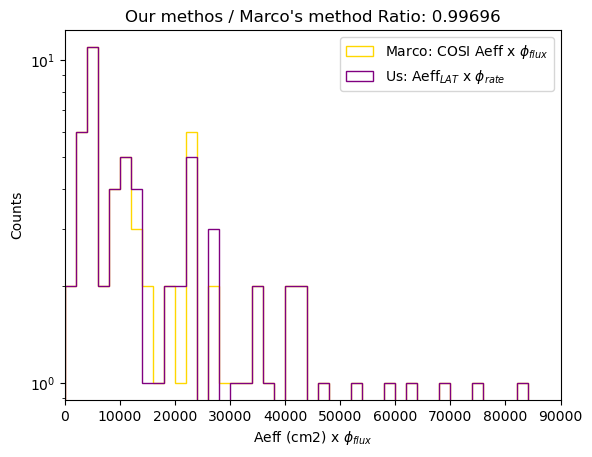

In [23]:
Aeffs_factors_f = 'COSICSV/COSI_factors_all_updated_only_logpar_flare_updated_60deg_offaxis_last.csv'
Aeffs_factors_df = pd.read_csv(Aeffs_factors_f)[-64:]

Aeff_COSI = Aeffs_factors_df['Aeff_mean_COSI(cm2)'].values
print(len(Aeff_COSI))
Aeff_LAT = Aeffs_factors_df['Aeff_mean_LAT(cm2)'].values
Rate_ratio = Aeffs_factors_df['ph/s_ratio'].values
Int_flux_ratio = Aeffs_factors_df['Int_flux_ratio'].values

# compare the distributions od Aeff_COSI and Aeff_LAT * Rate_ratio
plt.figure()
plt.hist(Aeff_COSI * Int_flux_ratio, label='Marco: COSI Aeff x $\phi_{flux}$', histtype='step', bins=50, lw=3, color='gold', range=(0, 1e5))
plt.hist(Aeff_LAT * Rate_ratio, label='Us: Aeff$_{LAT}$ x $\phi_{rate}$', histtype='step', bins=50, color='purple', lw=3, range=(0, 1e5))
plt.title('Our methos / Marco\'s method Ratio: %.5f'%(np.mean(Aeff_LAT * Rate_ratio) / np.mean(Aeff_COSI * Int_flux_ratio)))
plt.xlabel('Aeff (cm2) x $\phi_{flux}$')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.xlim(0, 9e4)
# plt.xscale('log')
# compute average Aeffs
avg_Aeff_COSI = np.mean(Int_flux_ratio * Aeff_COSI)
avg_Aeff_LAT = np.mean(Aeff_LAT * Rate_ratio )
print('Average Aeff COSI:', avg_Aeff_COSI)
print('Average Aeff LAT * Rate ratio:', avg_Aeff_LAT)

Eta = 0.1, Rate = 0.5, 26 Flares from 4 sources below 50.
Eta = 0.1, Rate = 0.5, 6 Flares from 1 sources below 20.
Eta = 0.3, Rate = 0.5, 55 Flares from 10 sources below 50.
Eta = 0.3, Rate = 0.5, 11 Flares from 3 sources below 20.
Eta = 0.5, Rate = 0.5, 66 Flares from 10 sources below 50.
Eta = 0.5, Rate = 0.5, 12 Flares from 3 sources below 20.


<Figure size 700x500 with 0 Axes>

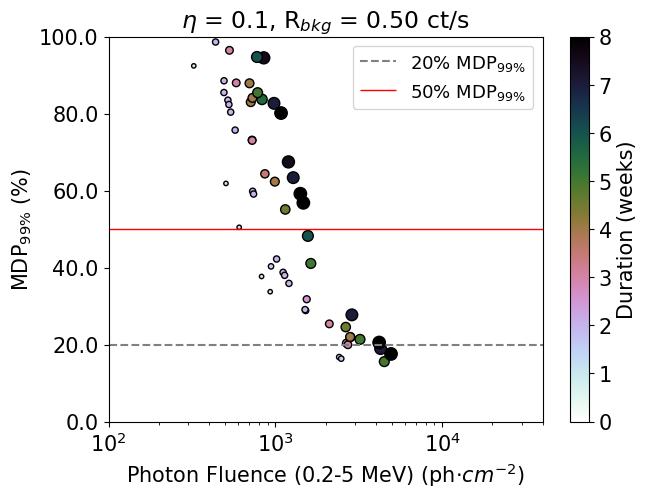

<Figure size 700x500 with 0 Axes>

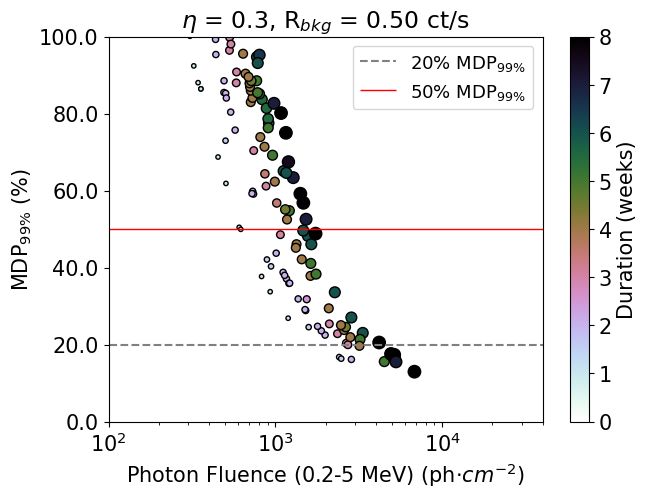

<Figure size 700x500 with 0 Axes>

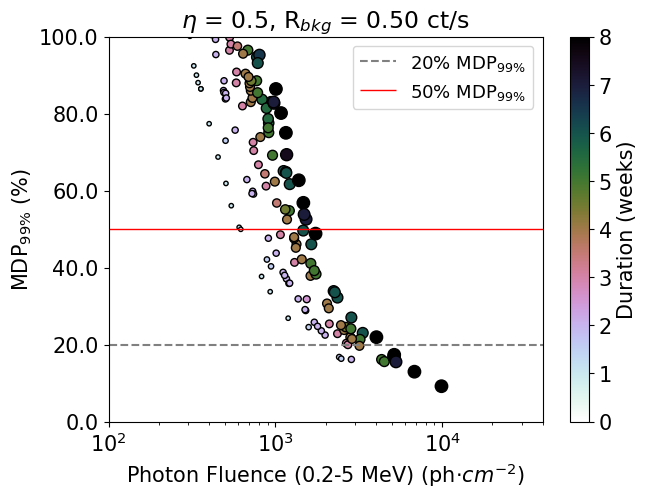

In [40]:
# f = ['RemadeNov2025/November2025_COSI_Eta0.1_bkg1.00.csv','RemadeNov2025/November2025_COSI_Eta0.1_bkg5.00.csv',
#     'RemadeNov2025/November2025_COSI_Eta0.1_bkg10.00.csv','RemadeNov2025/November2025_COSI_Eta0.1_bkg20.00.csv',
#     'RemadeNov2025/November2025_COSI_Eta0.3_bkg1.00.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg5.00.csv',
#     'RemadeNov2025/November2025_COSI_Eta0.3_bkg10.00.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg20.00.csv',
#     'RemadeNov2025/November2025_COSI_Eta0.5_bkg1.00.csv','RemadeNov2025/November2025_COSI_Eta0.5_bkg5.00.csv',
#     'RemadeNov2025/November2025_COSI_Eta0.5_bkg10.00.csv','RemadeNov2025/November2025_COSI_Eta0.5_bkg20.00.csv',
#     'RemadeNov2025/November2025_COSI_Eta0.1_bkg0.10.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg0.10.csv',
#     'RemadeNov2025/November2025_COSI_Eta0.5_bkg0.10.csv']
# f = ['RemadeNov2025/November2025_COSI_Eta0.1_bkg1.00softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.1_bkg5.00softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.1_bkg10.00softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.1_bkg20.00softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.3_bkg1.00softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg5.00softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.3_bkg10.00softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg20.00softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.5_bkg1.00softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.5_bkg5.00softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.5_bkg10.00softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.5_bkg20.00softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.1_bkg0.10softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg0.10softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.5_bkg0.10softer0.5.csv']
# backgrounds = [1.00,5.00,10.00,20.00,1.00,5.00,10.00,20.00,1.00,5.00,10.00,20.00,0.10,0.10,0.10]
# percents = [0.1,0.1,0.1,0.1,0.3,0.3,0.3,0.3,0.5,0.5,0.5,0.5,0.1,0.3,0.5]
f = ['RemadeNov2025/November2025_COSI_Eta0.1_bkg0.50.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg0.50.csv','RemadeNov2025/November2025_COSI_Eta0.5_bkg0.50.csv']
#f = ['RemadeNov2025/November2025_COSI_Eta0.1_bkg0.50softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg0.50softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.5_bkg0.50softer0.5.csv']

backgrounds = [0.5,0.5,0.5]
percents = [0.1,0.3,0.5]
for i in range(len(f)):
    COSI_BAND_BAT_weekly_df = pd.read_csv(f[i], sep=",", na_filter=True)
    COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Duration_(s)']!='0.0']
    COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[~COSI_BAND_BAT_weekly_df['Name'].isin(ignorelist)].reset_index(drop=True)    # COSI_BAND_BAT_weekly_df = pd.read_csv('RemadeNov2025/November2025_COSI_0.5_Eta0.10.csv', sep=",", na_filter=True)
    COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Source_Counts(ph)_(0.2-5_MeV)']!=-3333].reset_index(drop=True)
    # Filter all flares with duration greater than 100 weeks.
    COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Duration_(s)']<=4838400].reset_index(drop=True)
    #COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['MDP99_(%)']<=100].reset_index(drop=True)
    labelrate = backgrounds[i]
    labelpercent = percents[i]
    plt.figure(figsize = (7,5))
    fig,ax = plt.subplots(figsize = (7,5))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cm = plt.get_cmap('bwr_r')
    cm = plt.get_cmap('cubehelix_r')
    z = COSI_BAND_BAT_weekly_df['Duration_(s)']/604800
    #print(np.max(z))
    #sizes = COSI_BAND_BAT_weekly_df['Duration (s)']/604800
    sc = plt.scatter(COSI_BAND_BAT_weekly_df['Photon_Fluence_(ph/cm2)_(0.2-5_MeV)'],
                        COSI_BAND_BAT_weekly_df['MDP99_(%)'],
                        c=z, sizes=z*10,
                        cmap=cm,edgecolors='k',vmax=8, vmin = 0, zorder = 1)
    cbar = plt.colorbar(sc)
    cbar.set_label('Duration (weeks)', size = 15)
    cbar.ax.tick_params(labelsize=15)
    plt.ylim(0,100)
    #plt.xlim(np.min(COSI_BAND_BAT_weekly_df[:]['Photon Fluence (ph/cm2) (0.2-5 MeV)'])*0.1,np.max(COSI_BAND_BAT_weekly_df[:]['Photon Fluence (ph/cm2) (0.2-5 MeV)']))
    plt.xlim(100,40000)
    #plt.xlim(100,200000)
    plt.hlines(20,0,50000,colors='0.5', linestyles = 'dashed',label=r'20% MDP$_{99\%}$')
    plt.hlines(50,0,50000,colors = 'r', lw=1, label = r'50% MDP$_{99\%}$')
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel(r'Photon Fluence (0.2-5 MeV)' + ' (ph$\u22c5cm^{-2}$)', size=15)
    plt.ylabel(r'MDP$_{99\%}$ (%)', size = 15)
    #plt.title(r'R$_{bkg}$ = %.2f ph/s'%(labelrate) + r', $\eta$ = %.1f'%labelpercent + ', Modified Spectrum')
    plt.title(r'$\eta$ = %.1f'%labelpercent + r', R$_{bkg}$ = %.2f ct/s'%(labelrate), size=17)
    plt.legend(loc=0, fontsize=13)
    #plt.locator_params(axis='x', nbins=6)
    # make ticks and labels bigger
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    print('Eta = ' + str(percents[i])+ ', Rate = ' + str(backgrounds[i])+ ', ' + str(len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99_(%)']<=50]['Name']))+' Flares from '+str(len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99_(%)']<=50]['Name'].drop_duplicates())) + ' sources below 50.')
    print('Eta = ' + str(percents[i])+ ', Rate = ' + str(backgrounds[i])+ ', ' + str(len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99_(%)']<=20]['Name']))+' Flares from '+str(len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99_(%)']<=20]['Name'].drop_duplicates())) + ' sources below 20.')

    plt.savefig('RemadeNov2025/COSI_Duration_vs_PhotonFluence_Eta%.1f'%labelpercent+'_bkg%.2f'%(labelrate)+'.png', dpi=200, bbox_inches='tight')
    #plt.savefig('RemadeNov2025/COSI_Duration_vs_PhotonFluence_Eta%.1f'%labelpercent+'_bkg%.2f'%(labelrate)+'_softer0.5.png', dpi=200, bbox_inches='tight')





In [8]:
print('There are ', len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99 (%)']<=20].drop_duplicates(subset=['Name'],keep='first')),' sources with MDP99 <= 20')
print('There are ', len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99 (%)']<=20]),' flares with MDP99 <= 20')
#COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df['MDP99']<=20].to_csv('COSI_BAND_ALL_weekly_df_MDP99_20Test.csv')
#print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=20].drop_duplicates(subset=['Name']))

KeyError: 'MDP99 (%)'

In [5]:
# print('There are ', len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99 (%)']<=50].drop_duplicates(subset=['Name'],keep='first')),' sources with MDP99 <= 50')
# print('There are ', len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99 (%)']<=50]),' flares with MDP99 <= 50')
#COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=50]#.to_csv('COSI_BAND_ALL_weekly_df_MDP99_50_filtered.csv')
# print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99 (%)']<=50].drop_duplicates(subset=['Name'])['Name'])
lightcurveplottingnames = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99_(%)']<=100].drop_duplicates(subset=['Name'])['Name'].reset_index(drop=True)
lightcurveplottingnames

0     4FGL J0010.6+2043
1     4FGL J0024.7+0349
2     4FGL J0116.0-1136
3     4FGL J0200.6-6637
4     4FGL J0222.0-1616
            ...        
71    4FGL J0224.9+1843
72    4FGL J0336.4+3224
73    4FGL J2148.6+0652
74    4FGL J2202.7+4216
75    4FGL J2232.6+1143
Name: Name, Length: 76, dtype: object

### Duty Cycle Calculations

491
0    0.0
Name: Coverage, dtype: float64
1     0.005137
2     0.002283
3     0.018265
4     0.006279
5     0.006849
6     0.014840
7     0.002854
8     0.014269
9     0.007991
10    0.030822
11    0.004566
12    0.003995
13    0.004566
Name: Coverage, dtype: float64
14    0.0375
Name: Coverage, dtype: float64
15    0.069966
16    0.024460
17    0.035267
Name: Coverage, dtype: float64
18    0.013871
Name: Coverage, dtype: float64
19    0.093037
20    0.056507
Name: Coverage, dtype: float64
21    0.018065
22    0.006410
23    0.001166
Name: Coverage, dtype: float64
24    0.025597
25    0.047213
26    0.004551
27    0.031286
28    0.005688
29    0.011945
Name: Coverage, dtype: float64
30    0.010957
31    0.066321
Name: Coverage, dtype: float64
32    0.107843
Name: Coverage, dtype: float64
33    0.007955
34    0.004545
35    0.090341
36    0.101136
Name: Coverage, dtype: float64
37    0.005675
38    0.021566
Name: Coverage, dtype: float64
39    0.013636
40    0.001705
41    0.023864
42

C:\Users\bigge\AppData\Roaming\Python\Python310\site-packages\numpy\lib\_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


<Figure size 640x480 with 0 Axes>

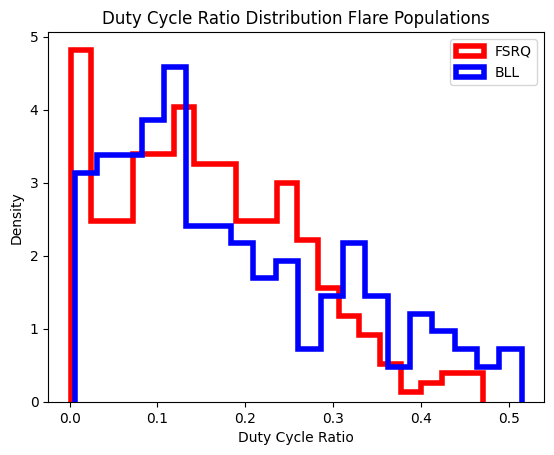

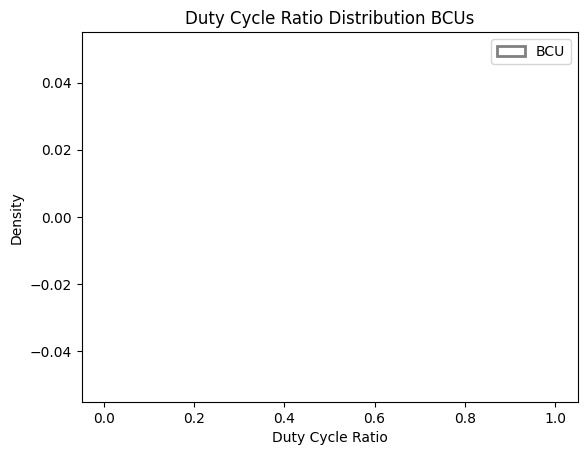

<Figure size 640x480 with 0 Axes>

In [16]:
# csv_string = 'RemadeNov2025/November2025_COSI_0.5_Eta0.05.csv'
dutycycle_arr=[0,0,0]
# COSI_BAND_BAT_weekly_df=pd.read_csv(csv_string)
COSI_BAND_BAT_weekly_df=COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Coverage']!=-3333].reset_index(drop=True)
#COSI_BAND_BAT_weekly_df = pd.read_csv('COSI+0.1Softer.csv')
print(len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1)
for i in range(0,len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1):
    sourcename = COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True)[i]
    if len(np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class']))>0:
        blazartype = np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class'])[-1]
    else:
        blazartype = 'None'
    #print(blazartype)
    dutycyclevalue = np.sum(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Coverage'])
    print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Coverage'])

    #print(flaringtime)
    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    #observation_time = np.max(sourcearray['tmin'])-np.min(sourcearray['tmin'])
    #obstime = (np.max(timearray)-np.min(timearray))*SecsInDay
    #print('obstime is',obstime)
    dutycycle = [sourcename,dutycyclevalue,blazartype]
    dutycycle_arr = np.vstack((dutycycle_arr,dutycycle))

# filtereddutycycles = pd.read_csv('RemadeNov2025/DutyCycles_Rbkg0.05_Eta0.3.csv', header=0)
filtereddutycycles = pd.DataFrame(dutycycle_arr)
filtereddutycycles.columns = ['Name','Duty Cycle','Class']
filtereddutycycles = filtereddutycycles[filtereddutycycles['Duty Cycle']!=-3333]
filtereddutycycles = filtereddutycycles[filtereddutycycles['Duty Cycle']!='0.0']
#pd.DataFrame(filtereddutycycles).sort_values(by=1).reset_index(drop=True).to_csv('Diagrams/Aug2025Plots/DutyCycles_Eta%.1f'%percent+file_suffix+'.csv',index=False)


plt.figure()
plt.hist(x=filtereddutycycles[filtereddutycycles['Class']=='FSRQ']['Duty Cycle'].astype(float),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Ratio Distribution of FSRQs')
plt.hist(x=filtereddutycycles[filtereddutycycles['Class']=='BLL']['Duty Cycle'].astype(float),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Ratio Distribution Flare Populations')
plt.figure()
#plt.savefig('Diagrams/Aug2025Plots/DutyCycles_FSRQ&BLL_Eta%.1f'%percent+file_suffix+'png',dpi=200)

plt.hist(x=filtereddutycycles[filtereddutycycles['Class']=='BCU']['Duty Cycle'].astype(float),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Ratio Distribution BCUs')
plt.figure()
#plt.savefig('Diagrams/Aug2025Plots/DutyCycles_BCU_Eta%.1f'%percent+file_suffix+'png',dpi=200)
#plt.savefig('DutyCycles/DutyCycle_BCU_0.5.png')

In [17]:
dutycycle_arr=[0,0,0]
#COSI_BAND_BAT_weekly_df=pd.read_csv('Aug2025_COSI_0.5_(0.1 Counts).csv')
#COSI_BAND_BAT_weekly_df = pd.read_csv('COSI+0.1Softer.csv')
print(len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1)
for i in range(0,len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1):
    sourcename = COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True)[i]
    if len(np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class']))>0:
        blazartype = np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class'])[-1]
    else:
        blazartype = 'None'
    #print(blazartype)
    dutycyclevalue = np.sum(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])
    print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])

    #print(flaringtime)
    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    #observation_time = np.max(sourcearray['tmin'])-np.min(sourcearray['tmin'])
    #obstime = (np.max(timearray)-np.min(timearray))*SecsInDay
    #print('obstime is',obstime)
    dutycycle = [sourcename,dutycyclevalue,blazartype]
    dutycycle_arr = np.vstack((dutycycle_arr,dutycycle))

491


KeyError: 'Fraction of Observation Time'

Text(0.5, 1.0, 'Duty Cycle Ratio Distribution BCUs')

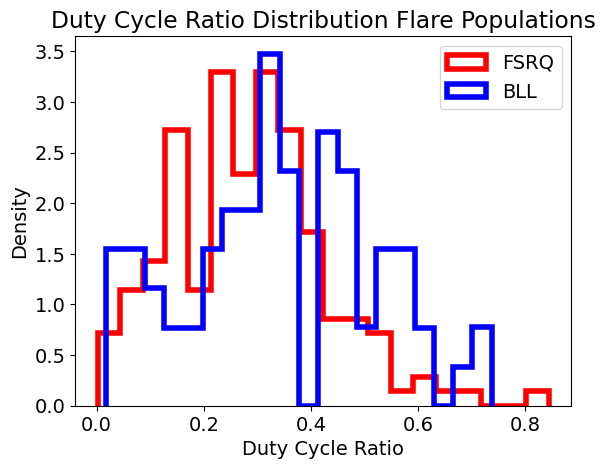

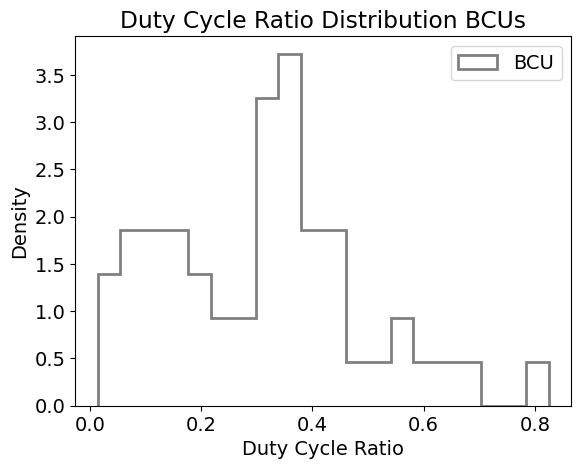

In [85]:
filtereddutycycles = dutycycle_arr[dutycycle_arr[:,1]!='1.0']
#pd.DataFrame(filtereddutycycles).sort_values(by=1).reset_index(drop=True).to_csv('DutyCyclesFSRQBLL.csv',index=False)
plt.figure()
plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Ratio Distribution of FSRQs')
plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Ratio Distribution Flare Populations')
plt.figure()
#plt.savefig('DutyCycles/DutyCycle_FSRQ+BLL_0.5.png')

plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Ratio Distribution BCUs')
#plt.savefig('DutyCycles/DutyCycle_BCU_0.5.png')
#plt.yscale('log')
#plt.xscale('log')

<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_78966/1607201424.py:47: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_fsrq_refine,maxfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
/tmp/ipykernel_78966/1607201424.py:47: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fsrq_refine,maxfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\s

0.18501916526644632 0.24240379123381456


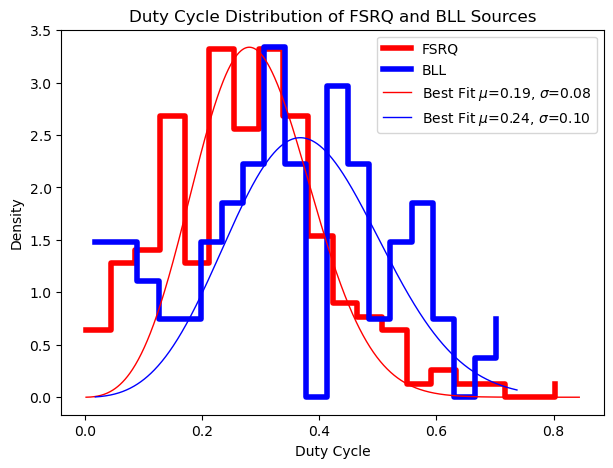

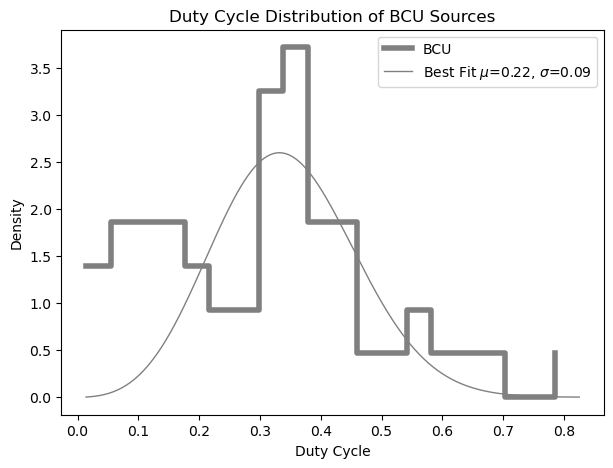

In [128]:
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit


def maxwellian_function(x, N, a):
    mu = 2*a*(np.sqrt(2/np.pi))
    return N * (x**2*np.exp(-(x - mu)**2/(2*a**2)))/a**3


y_fsrq,xe_fsrq=np.histogram(filtereddutycycles[filtereddutycycles['Class']=='FSRQ']['Duty Cycle'].astype(float),bins=20,density=True)
x_fsrq = (xe_fsrq[:-1]+xe_fsrq[1:])/2
x_fsrq_refine = np.linspace(xe_fsrq[0],xe_fsrq[-1],1000)
y_bll,xe_bll=np.histogram(filtereddutycycles[filtereddutycycles['Class']=='BLL']['Duty Cycle'].astype(float),bins=20,density=True)
x_bll = (xe_bll[:-1]+xe_bll[1:])/2
x_bll_refine = np.linspace(xe_bll[0],xe_bll[-1],1000)
y_bcu,xe_bcu=np.histogram(filtereddutycycles[filtereddutycycles['Class']=='BCU']['Duty Cycle'].astype(float),bins=20,density=True)
x_bcu = (xe_bcu[:-1]+xe_bcu[1:])/2
x_bcu_refine = np.linspace(xe_bcu[0],xe_bcu[-1],1000)


maxfsrq=maxwellian_function(x_fsrq,0.1,a=0.1)
popt_fsrq, pcov_fsrq = curve_fit(maxwellian_function, x_fsrq, y_fsrq,p0=[0.1,0.1],maxfev=5000)
fsrq_mean = 2 * popt_fsrq[1] * np.sqrt(2 / np.pi)
fsrq_std = np.sqrt((popt_fsrq[1]**2 * (3 * np.pi - 8)) / np.pi)
maxfsrq = maxwellian_function(x_fsrq_refine,popt_fsrq[0],popt_fsrq[1])

maxbll=maxwellian_function(x_bll,0.1,a=0.1)
popt_bll, pcov_bll = curve_fit(maxwellian_function, x_bll, y_bll,p0=[0.1,0.1],maxfev=5000)
bll_mean = 2 * popt_bll[1] * np.sqrt(2 / np.pi)
bll_std = np.sqrt((popt_bll[1]**2 * (3 * np.pi - 8)) / np.pi)
maxbll=maxwellian_function(x_bll_refine,popt_bll[0],popt_bll[1])

maxbcu=maxwellian_function(x_bcu,0.1,a=0.1)
popt_bcu, pcov_bcu = curve_fit(maxwellian_function, x_bcu, y_bcu,p0=[0.1,0.1],maxfev=5000)
bcu_mean = 2 * popt_bcu[1] * np.sqrt(2 / np.pi)
bcu_std = np.sqrt((popt_bcu[1]**2 * (3 * np.pi - 8)) / np.pi)
maxbcu = maxwellian_function(x_bcu_refine,popt_bcu[0],popt_bcu[1])

fig,ax = plt.subplots(figsize = (7,5))
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float)),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float)),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float)),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)

plt.step(xe_fsrq[:-1],y_fsrq,where='post',color='r',linewidth=4,label='FSRQ')
plt.step(xe_bll[:-1],y_bll,where='post',color='blue',linewidth=4,label='BLL')
#plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4)
plt.plot(x_fsrq_refine,maxfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
plt.plot(x_bll_refine,maxbll,color='blue',linewidth=1,label=f'Best Fit $\mu$={bll_mean:0.2f}, $\sigma$={bll_std:0.2f}')
#plt.plot(x_bcu_refine,maxbcu,color='grey')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle')
plt.title('Duty Cycle Distribution of FSRQ and BLL Sources')
#plt.savefig('DutyCycles/DutyCycle_FSRQ+BLL_0.5_fit.png')


fig,ax = plt.subplots(figsize = (7,5))
plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4,label='BCU')
plt.plot(x_bcu_refine,maxbcu,color='grey',linewidth=1,label=f'Best Fit $\mu$={bcu_mean:0.2f}, $\sigma$={bcu_std:0.2f}')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle')
plt.title('Duty Cycle Distribution of BCU Sources')
#plt.savefig('DutyCycles/DutyCycle_BCU_0.5_fit.png')
print(fsrq_mean,bll_mean)


In [79]:
print(x_fsrq[y_fsrq.argmax()])
print(x_bll[y_bll.argmax()])
print(x_bcu[y_bcu.argmax()])

0.24474666388657207
0.36630062961677634
0.29412228144320185


In [80]:
x_fsrq

array([0.02197352, 0.05910238, 0.09623123, 0.13336009, 0.17048895,
       0.20761781, 0.24474666, 0.28187552, 0.31900438, 0.35613324,
       0.39326209, 0.43039095, 0.46751981, 0.50464867, 0.54177752,
       0.57890638, 0.61603524, 0.6531641 , 0.69029295, 0.72742181])

In [168]:
stats.ks_2samp(data1=filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),data2 = filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float))

KstestResult(statistic=np.float64(0.3354024829795755), pvalue=np.float64(7.587007727346903e-07), statistic_location=np.float64(0.30501710376282765), statistic_sign=np.int8(1))

### Plotting Distribution of New Flares

In [16]:
#FlareTable = pd.read_csv('COSI_BAND_ALL_weekly_RbkgUpdated0.10.csv', sep=",", na_filter=True)
FlareTable = COSI_BAND_BAT_weekly_df
fsrq_flares = FlareTable[FlareTable['Class']=='FSRQ']
fsrq_flares = fsrq_flares[fsrq_flares['Photon Flux (ph/cm2/s)']<100]
fsrq_flares = fsrq_flares[fsrq_flares['Photon Flux (ph/cm2/s)']>10e-12]
bll_flares = FlareTable[FlareTable['Class']=='BLL']
bll_flares = bll_flares[bll_flares['Photon Flux (ph/cm2/s)']<100]
bll_flares = bll_flares[bll_flares['Photon Flux (ph/cm2/s)']>10e-12]
bcu_flares = FlareTable[FlareTable['Class']=='BCU']
bcu_flares = bcu_flares[bcu_flares['Photon Flux (ph/cm2/s)']<100]
bcu_flares = bcu_flares[bcu_flares['Photon Flux (ph/cm2/s)']>10e-12]
FlareTable = FlareTable[FlareTable['Photon Flux (ph/cm2/s)']<100]
FlareTable = FlareTable[FlareTable['Photon Flux (ph/cm2/s)']>10e-12]

<function matplotlib.pyplot.show(close=None, block=None)>

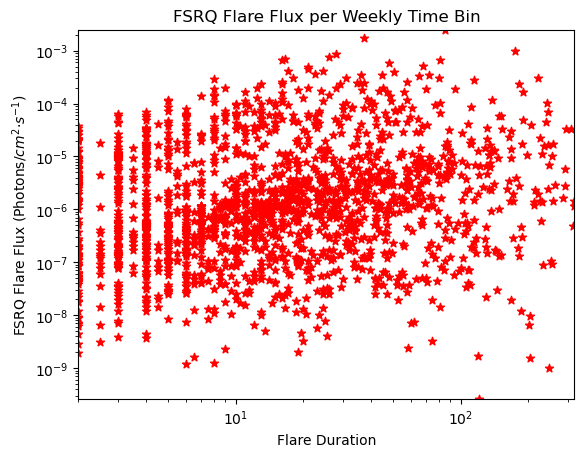

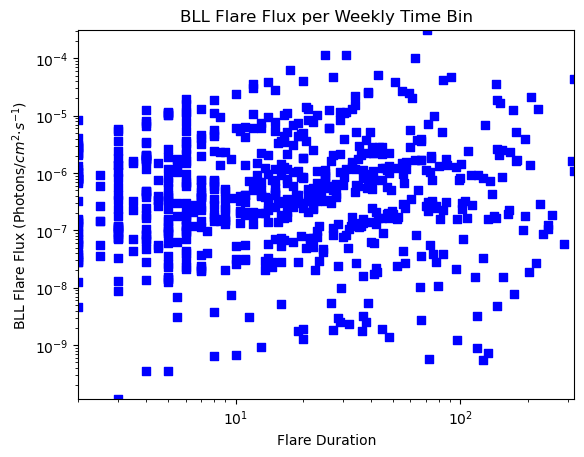

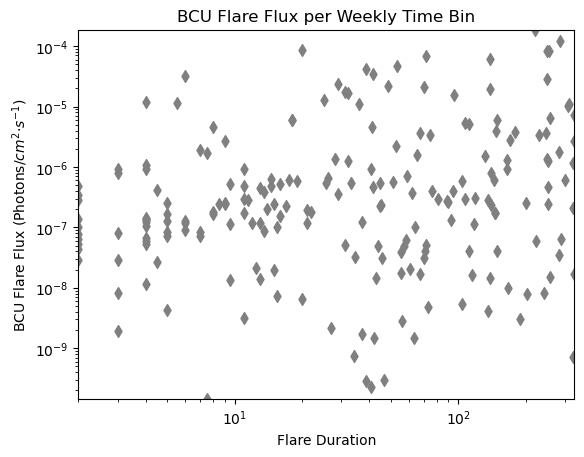

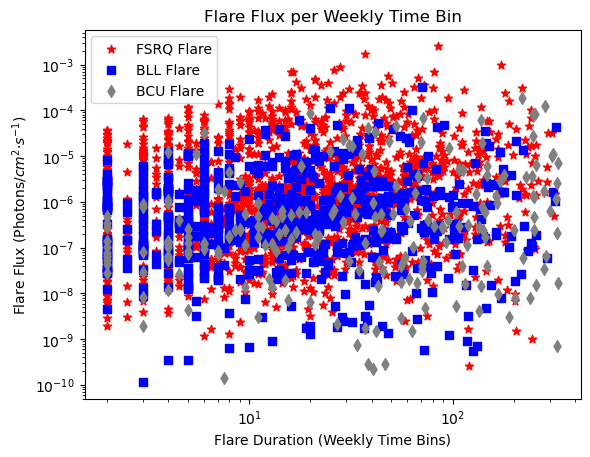

In [17]:
cl = ['r','blue','gray'] # List of colours for categories


# This section makes four Average Flux vs Duration plots: one for each category of blazars, and a final plot for all three together.
#print(pd.DataFrame(fsrq_flares[:,1]))
fsrq_ysize = fsrq_flares['Photon Flux (ph/cm2/s)'].size
fsrq_x = np.asarray(fsrq_flares['Duration (weeks)'],dtype='float64')
fsrq_xmin = min(fsrq_x)
fsrq_xmax = max(fsrq_x)
fsrq_y = np.asarray(fsrq_flares['Photon Flux (ph/cm2/s)'],dtype='float64')
fsrq_ymin = min(fsrq_y)
fsrq_ymax = max(fsrq_y)
#fsrq_err= np.asarray(fsrq_plot[:,3],dtype='float64')
plt.ylim([fsrq_ymin,fsrq_ymax])
plt.xlim([fsrq_xmin,fsrq_xmax])
plt.scatter(fsrq_x,fsrq_y,marker = '*',color=cl[0])
#plt.errorbar(fsrq_x,fsrq_y,,fmt = '*',color='#FF005D')
plt.ylabel('FSRQ Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration')
plt.title('FSRQ Flare Flux per Weekly Time Bin')
plt.yscale('log')
plt.xscale('log')
plt.figure()

bll_ysize = bll_flares['Photon Flux (ph/cm2/s)'].size
bll_x = np.asarray(bll_flares['Duration (weeks)'],dtype='float64')
bll_xmin = min(bll_x)
bll_xmax = max(bll_x)
bll_y = np.asarray(bll_flares['Photon Flux (ph/cm2/s)'],dtype='float64')
bll_ymin = min(bll_y)
bll_ymax = max(bll_y)
#bll_err= np.asarray(bll_plot[:,3],dtype='float64')
plt.ylim([bll_ymin,bll_ymax])
plt.xlim([bll_xmin,bll_xmax])
plt.scatter(bll_x,bll_y,marker = 's',color=cl[1])
#plt.errorbar(bll_x,bll_y,,fmt = '*',color='#FF005D')
plt.ylabel('BLL Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration')
plt.title('BLL Flare Flux per Weekly Time Bin')
plt.yscale('log')
plt.xscale('log')
plt.figure()

bcu_ysize = bcu_flares['Photon Flux (ph/cm2/s)'].size
bcu_x = np.asarray(bcu_flares['Duration (weeks)'],dtype='float64')
bcu_xmin = min(bcu_x)
bcu_xmax = max(bcu_x)
bcu_y = np.asarray(bcu_flares['Photon Flux (ph/cm2/s)'],dtype='float64')
bcu_ymin = min(bcu_y)
bcu_ymax = max(bcu_y)
#bcu_err= np.asarray(bcu_plot[:,3],dtype='float64')
plt.ylim([bcu_ymin,bcu_ymax])
plt.xlim([bcu_xmin,bcu_xmax])
plt.scatter(bcu_x,bcu_y,marker = 'd',color=cl[2])
#plt.errorbar(bcu_x,bcu_y,,fmt = '*',color='#FF005D')
plt.ylabel('BCU Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration')
plt.title('BCU Flare Flux per Weekly Time Bin')
plt.yscale('log')
plt.xscale('log')
plt.figure()



#Combined Graphic
plt.scatter(fsrq_x,fsrq_y,marker = '*',color=cl[0],label='FSRQ Flare')
#plt.errorbar(fsrq_x,fsrq_y,yerr=fsrq_err,fmt = '*',color='#FF005D')
plt.scatter(bll_x,bll_y,marker = 's',color=cl[1],label='BLL Flare')
#plt.errorbar(bll_x,bll_y,yerr=bll_err,fmt = 's',color='#1E88E5')
plt.scatter(bcu_x,bcu_y,marker = 'd',color=cl[2],label='BCU Flare')
#plt.errorbar(bcu_x,bcu_y,yerr=bcu_err,fmt = 'd',color='#FFC107')
plt.legend()
plt.ylabel('Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration (Weekly Time Bins)')
plt.title('Flare Flux per Weekly Time Bin')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(10,40)
#plt.ylim(0.0000001,0.000002)
plt.show
#Flux is 1/cm^2*s


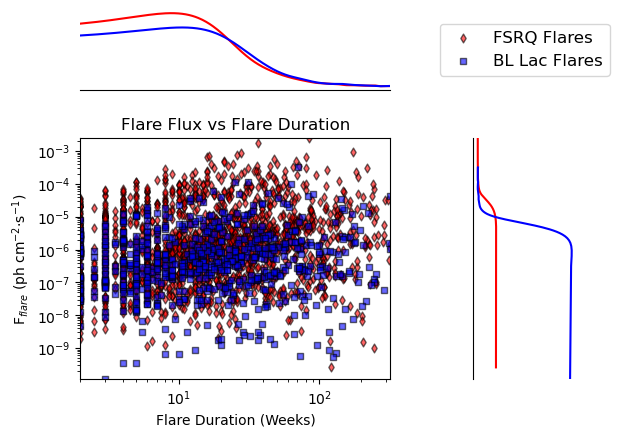

In [18]:
from matplotlib import gridspec

# Graph modified for Weekly Cadence
label = ['FSRQ Flares','BL Lac Flares','BCU Flares'] # List of labels for categories
cl = ['r','blue','gray'] # List of colours for categories
categories = len(label)


# Set up 4 subplots as axis objects using GridSpec:
gs = gridspec.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[1,3])
# Add space between scatter plot and KDE plots to accommodate axis labels:
gs.update(hspace=0.3, wspace=0.4)

# Set background canvas colour to White instead of grey default
fig = plt.figure()
fig.patch.set_facecolor('white')

ax = plt.subplot(gs[1,0]) # Instantiate scatter plot area and axis range
#ax.set_ylim(10**-8,10**-5)
#ax.set_xlim(10,100)
ax.set_xlim(min(fsrq_xmin,bll_xmin), max(fsrq_xmax,bll_xmax))
ax.set_ylim(min(fsrq_ymin,bll_ymin), max(fsrq_ymax,bll_ymax))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Flare Duration (Weeks)')
ax.set_ylabel('F$_{flare}$ (ph cm$^{-2}$\u22c5s$^{-1}$)')
ax.set_title('Flare Flux vs Flare Duration')

axl = plt.subplot(gs[1,1], sharey=ax) # Instantiate left KDE plot area
axl.get_xaxis().set_visible(False) # Hide tick marks and spines
axl.get_yaxis().set_visible(False)
axl.spines["right"].set_visible(False)
axl.spines["top"].set_visible(False)
axl.spines["bottom"].set_visible(False)

axb = plt.subplot(gs[0,0], sharex=ax) # Instantiate bottom KDE plot area
axb.get_xaxis().set_visible(False) # Hide tick marks and spines
axb.get_yaxis().set_visible(False)
axb.spines["right"].set_visible(False)
axb.spines["top"].set_visible(False)
axb.spines["left"].set_visible(False)

axc = plt.subplot(gs[0,1]) # Instantiate legend plot area
axc.axis('off') # Hide tick marks and spines

# Plot data for each categorical variable as scatter and marginal KDE plots:
#FSRQ PLOT
ax.scatter(fsrq_x, fsrq_y, marker = 'd', color = cl[0], label=label[0], s=20, edgecolors= 'black',alpha = 0.6)
#ax.errorbar(fsrq_x*3,fsrq_y,yerr=fsrq_err,fmt = '*',color='#FF005D')    
kde = stats.gaussian_kde(fsrq_x)
fsrq_xx = np.linspace(fsrq_xmin,fsrq_xmax,1000)
axb.plot(fsrq_xx,kde(fsrq_xx), color=cl[0],)
kde = stats.gaussian_kde(fsrq_y)
fsrq_yy = np.linspace(fsrq_ymin,fsrq_ymax,1000)
axl.plot(kde(fsrq_yy), fsrq_yy, color=cl[0])

#BLL PLOT
ax.scatter(bll_x,bll_y, marker = 's', color=cl[1], label=label[1], s=20, edgecolors = 'black',alpha = 0.6)
plt.xlim(np.log(10),np.max([np.max(fsrq_x.astype(float)),np.max(bll_x.astype(float))]))
#ax.errorbar(bll_x*3,bll_y,yerr=bll_err,fmt = 's',color='#1E88E5')
kde = stats.gaussian_kde(bll_x)
bll_xx = np.linspace(bll_xmin,bll_xmax,1000)
axb.plot(bll_xx, kde(bll_xx), color=cl[1])
kde = stats.gaussian_kde(bll_y)
bll_yy = np.linspace(bll_ymin,bll_ymax,1000)
axl.plot(kde(bll_yy), bll_yy, color=cl[1])

#BCU PLOT
#ax.scatter(bcu_x,bcu_y, marker = 'd', color=cl[2], label=label[2], s=20, edgecolor= cl[2])
#ax.errorbar(bcu_x*3,bcu_y,yerr=bcu_err,fmt = 'd',color='#FFC107')

#kde = stats.gaussian_kde(bcu_x)
#bcu_xx = np.linspace(bcu_xmin,bcu_xmax,1000)
#axb.plot(bcu_xx, kde(bcu_xx), color=cl[2])
#kde = stats.gaussian_kde(bcu_y)
#bcu_yy = np.linspace(bcu_ymin,bcu_ymax,1000)
#axl.plot(kde(bcu_yy), bcu_yy, color=cl[2])

# Copy legend object from scatter plot to lower left subplot and display:
# NB 'scatterpoints = 1' customises legend box to show only 1 handle (icon) per label 
handles, labels = ax.get_legend_handles_labels()
axc.legend(handles, labels, scatterpoints = 1, loc = 'center', fontsize = 12)
plt.show()

In [19]:
np.min(fsrq_x)

np.float64(2.0)

In [20]:

fsrq_filtered = fsrq_flares
fsrq_flareduration = fsrq_filtered['Duration (weeks)']
fsrq_flareflux = fsrq_filtered['Photon Flux (ph/cm2/s)']
#fsrq_flareflux_error = fsrq_filtered[]
fsrq_flareduration=np.asarray(fsrq_flareduration,dtype='float64')
fsrq_flareflux=np.asarray(fsrq_flareflux,dtype='float64')
#fsrq_flareflux_error=np.asarray(fsrq_flareflux_error,dtype='float64')
fsrq_fluence = np.multiply(fsrq_flareflux,fsrq_flareduration)*(7*24*60*60)
#fsrq_fluence_error = (np.multiply(fsrq_flareflux_error,fsrq_flareduration)**2)**0.5
#pd.DataFrame(fsrq_flareduration)
#pd.DataFrame(fsrq_flareflux)
pd.DataFrame(fsrq_fluence)
fsrq_fluencecount = np.zeros(len(fsrq_fluence))
#fsrq_fluencecount_error = np.zeros(len(fsrq_fluence))
fsrq_fluencethresholds=sorted(fsrq_fluence)
for i in range(0,len(fsrq_fluence)):
    fsrq_fluencecount[i]=len(fsrq_fluence[fsrq_fluence>fsrq_fluencethresholds[i]])
    #fsrq_fluencecount_error[i]=fsrq_fluencecount[i]**0.5
pd.DataFrame(fsrq_fluencethresholds)

bll_filtered = bll_flares
bll_flareduration = bll_filtered['Duration (weeks)']
bll_flareflux = bll_filtered['Photon Flux (ph/cm2/s)']
#bll_flareflux_error = bll_filtered[:,3]
bll_flareduration=np.asarray(bll_flareduration,dtype='float64')
bll_flareflux=np.asarray(bll_flareflux,dtype='float64')
#bll_flareflux_error=np.asarray(bll_flareflux_error,dtype='float64')
bll_fluence = np.multiply(bll_flareflux,bll_flareduration)*(7*24*60*60)
#pd.DataFrame(bll_flareduration)
#pd.DataFrame(bll_flareflux)
pd.DataFrame(bll_fluence)
bll_fluencecount = np.zeros(len(bll_fluence))
#bll_fluencecount_error = np.zeros(len(bll_fluence))

bll_fluencethresholds=sorted(bll_fluence)
for i in range(0,len(bll_fluence)):
    bll_fluencecount[i]=len(bll_fluence[bll_fluence>bll_fluencethresholds[i]])
    #bll_fluencecount_error[i]=bll_fluencecount[i]**0.5

pd.DataFrame(bll_fluencethresholds)


bcu_filtered = bcu_flares
bcu_flareduration = bcu_filtered['Duration (weeks)']
bcu_flareflux = bcu_filtered['Photon Flux (ph/cm2/s)']
#bcu_flareflux_error = bcu_filtered[:,3]
bcu_flareduration=np.asarray(bcu_flareduration,dtype='float64')*(7*24*60*60)
bcu_flareflux=np.asarray(bcu_flareflux,dtype='float64')
#bcu_flareflux_error=np.asarray(bcu_flareflux_error,dtype='float64')
bcu_fluence = np.multiply(bcu_flareflux,bcu_flareduration)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(bcu_fluence)
bcu_fluencecount = np.zeros(len(bcu_fluence))
#bcu_fluencecount_error = np.zeros(len(bcu_fluence))

bcu_fluencethresholds=sorted(bcu_fluence)
for i in range(0,len(bcu_fluence)):
    bcu_fluencecount[i]=len(bcu_fluence[bcu_fluence>bcu_fluencethresholds[i]])
    #bcu_fluencecount_error[i]=bcu_fluencecount[i]**0.5

pd.DataFrame(bcu_fluencethresholds)

total_filtered = FlareTable
total_flareduration = total_filtered['Duration (weeks)']
total_flareflux = total_filtered['Photon Flux (ph/cm2/s)']
#total_flareflux_error = total_filtered[:,3]
total_flareduration=np.asarray(total_flareduration,dtype='float64')
total_flareflux=np.asarray(total_flareflux,dtype='float64')
total_fluence = np.multiply(total_flareflux,total_flareduration)*(7*24*60*60)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(total_fluence)
total_fluencecount = np.zeros(len(total_fluence))
#total_fluencecount_error = np.zeros(len(total_fluence))
total_fluencethresholds=sorted(total_fluence)
for i in range(0,len(total_fluence)):
    total_fluencecount[i]=len(total_fluence[total_fluence>total_fluencethresholds[i]])
    #total_fluencecount_error[i]=total_fluencecount[i]**0.5
print(max(total_fluencecount))

#np.save('shared_plot_arrays/FERMI_fsrq_fluencecount_0.1.npy',np.array(fsrq_fluencecount))
#np.save('shared_plot_arrays/FERMI_bll_fluencecount_0.1.npy',np.array(bll_fluencecount_error))
#np.save('shared_plot_arrays/FERMI_bcu_fluencecount_0.1.npy',np.array(bcu_fluencecount_error))


2959.0


In [21]:
fsrqDataframe = pd.DataFrame([fsrq_fluencecount,fsrq_fluencethresholds]).transpose()
fsrqDataframe.rename(columns={0:'# of Flares',1:'Detection Threshold (ph/cm^2)'},inplace=True)

bllDataframe = pd.DataFrame([bll_fluencecount,bll_fluencethresholds]).transpose()
bllDataframe.rename(columns={0:'# of Flares',1:'Detection Threshold (ph/cm^2)'},inplace=True)

bcuDataframe = pd.DataFrame([bcu_fluencecount,bcu_fluencethresholds]).transpose()
bcuDataframe.rename(columns={0:'# of Flares',1:'Detection Threshold (ph/cm^2)'},inplace=True)

totalDataframe = pd.DataFrame([total_fluencecount,total_fluencethresholds]).transpose()
totalDataframe.rename(columns={0:'# of Flares',1:'Detection Threshold (ph/cm^2)'},inplace=True)

fsrqDataframe.to_csv('shared_plot_arrays/FERMI_fsrq_fluence_curve_0.3.csv',index=False)
bllDataframe.to_csv('shared_plot_arrays/FERMI_bll_fluence_curve_0.3.csv',index=False)
bcuDataframe.to_csv('shared_plot_arrays/FERMI_bcu_fluence_curve_0.3.csv',index=False)
totalDataframe.to_csv('shared_plot_arrays/FERMI_total_fluence_curve_0.3.csv',index = False)

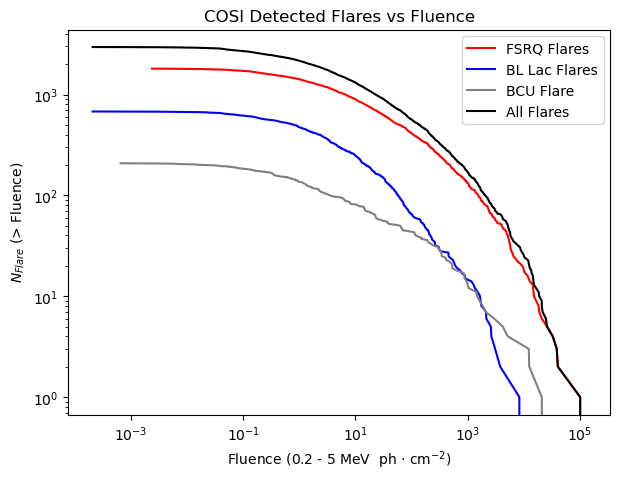

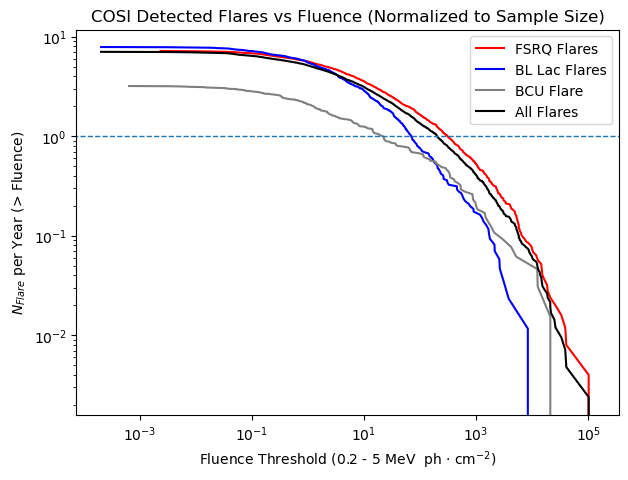

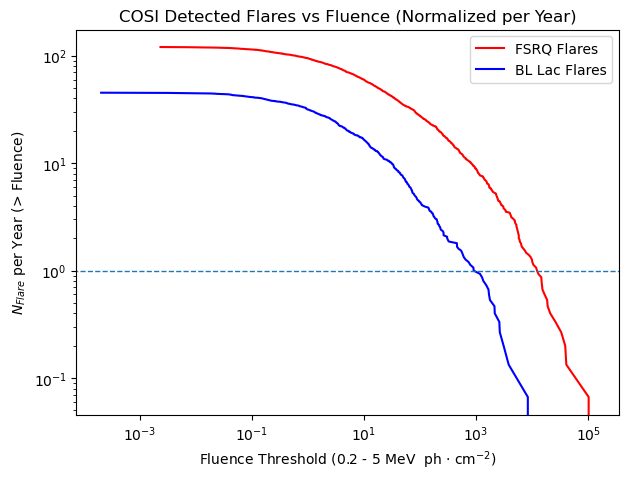

In [22]:
label = ['FSRQ Flares','BL Lac Flares','BCU Flare','All Flares'] # List of labels for categories
cl = ['r','blue','gray','000000'] # List of colours for categories

fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.plot(fsrq_fluencethresholds,fsrq_fluencecount, color=cl[0], label=label[0])
#plt.errorbar(fsrq_fluencethresholds,fsrq_fluencecount, yerr=fsrq_fluencecount_error, color=cl[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/cm^2)')



plt.plot(bll_fluencethresholds,bll_fluencecount, color=cl[1], label=label[1])
#plt.errorbar(bll_fluencethresholds,bll_fluencecount, yerr=bll_fluencecount_error, color=cl[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')


plt.plot(bcu_fluencethresholds,bcu_fluencecount, color=cl[2], label=label[2])
#plt.errorbar(bcu_fluencethresholds,bcu_fluencecount, yerr=bcu_fluencecount_error, color=cl[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')


plt.plot(total_fluencethresholds,total_fluencecount, color=cl[3], label=label[3])
#plt.errorbar(total_fluencethresholds,total_fluencecount, yerr=total_fluencecount_error, color=cl[3])
plt.yscale('log')
#plt.ylim(9,10**4)
#plt.xlim(10**-4,10**8)
plt.xscale('log')
plt.ylabel('$N_{Flare}$ (> Fluence)')
plt.xlabel('Fluence (0.2 - 5 MeV  ph \u22c5 cm$^{-2}$)')
plt.title('COSI Detected Flares vs Fluence')

plt.legend()

fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.plot(fsrq_fluencethresholds,fsrq_fluencecount/len(fsrq_flares['Name'].drop_duplicates(keep='first')), color=cl[0], label=label[0])
#plt.errorbar(fsrq_fluencethresholds,fsrq_fluencecount/15, yerr=fsrq_fluencecount_error/15, color=cl[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photns/cm^2)')

plt.plot(bll_fluencethresholds,bll_fluencecount/len(bll_flares['Name'].drop_duplicates(keep='first')), color=cl[1], label=label[1])
#plt.errorbar(bll_fluencethresholds,bll_fluencecount/15, yerr=bll_fluencecount_error/15, color=cl[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(bcu_fluencethresholds,bcu_fluencecount/len(bcu_flares['Name'].drop_duplicates(keep='first')), color=cl[2], label=label[2])
#plt.errorbar(bcu_fluencethresholds,bcu_fluencecount/15, yerr=bcu_fluencecount_error/15, color=cl[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(total_fluencethresholds,total_fluencecount/len(FlareTable['Name'].drop_duplicates(keep='first')), color=cl[3], label=label[3])
#plt.errorbar(total_fluencethresholds,total_fluencecount/15, yerr=total_fluencecount_error/15, color=cl[3])
plt.yscale('log')
plt.xscale('log')
#plt.ylim(10/15,10**3)
#plt.xlim(10**-4,10**8)
plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.2 - 5 MeV  ph \u22c5 cm$^{-2}$)')
plt.title('COSI Detected Flares vs Fluence (Normalized to Sample Size)')
plt.hlines(1,10**-10,10**10,linewidth=1,linestyles='--')
plt.legend()


fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.plot(fsrq_fluencethresholds,fsrq_fluencecount/15, color=cl[0], label=label[0])
#plt.errorbar(fsrq_fluencethresholds,fsrq_fluencecount/15, yerr=fsrq_fluencecount_error/15, color=cl[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photns/cm^2)')

plt.plot(bll_fluencethresholds,bll_fluencecount/15, color=cl[1], label=label[1])
#plt.errorbar(bll_fluencethresholds,bll_fluencecount/15, yerr=bll_fluencecount_error/15, color=cl[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

#plt.plot(bcu_fluencethresholds,bcu_fluencecount/15, color=cl[2], label=label[2])
#plt.errorbar(bcu_fluencethresholds,bcu_fluencecount/15, yerr=bcu_fluencecount_error/15, color=cl[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

#plt.plot(total_fluencethresholds,total_fluencecount/15, color=cl[3], label=label[3])
#plt.errorbar(total_fluencethresholds,total_fluencecount/15, yerr=total_fluencecount_error/15, color=cl[3])
plt.yscale('log')
plt.xscale('log')
#plt.ylim(10/15,10**3)
#plt.xlim(10**-4,10**8)
plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.2 - 5 MeV  ph \u22c5 cm$^{-2}$)')
plt.title('COSI Detected Flares vs Fluence (Normalized per Year)')
plt.hlines(1,10**-10,10**10,linewidth=1,linestyles='--')
#plt.ylim(1,np.max(fsrq_fluencecount))

plt.legend()


4.19e-05 2.26e-09 4.189774e-05 2.094887e-05 2.095113e-05
Quiescent Background: 1.208942911694511e-06, Error: 2.9735553081359164e-09
printing quiescent background
1.208942911694511e-06
55645.50001157408


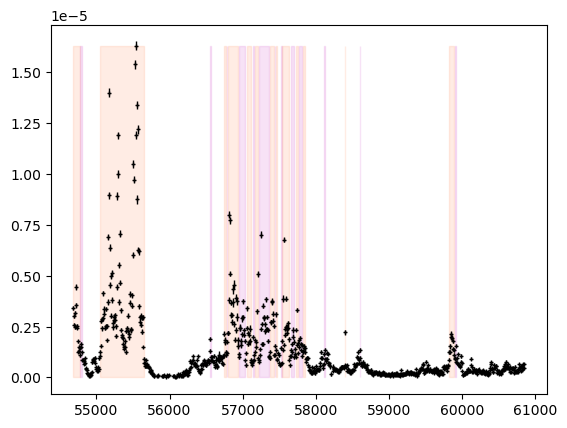

In [21]:
percent = 0.5

sourcename = '4FGL J2253.9+1609'
#
#if sourcename == '4FGL J1036.3-5833e':
#    continue
#if sourcename == '4FGL J1855.9+0121e':
#    continue
#if sourcename == '4FGL J1923.2+1408e':
#    continue

sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename

sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.nanmean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2']
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux = np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent
#thresholdflux = np.nanmean(photon_flux)
print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)

if not sourcelightcurve.hops:
    print('no hops found in first run')

quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward')

if quiescent_background == np.nan:
    print('background is nan')
print('printing quiescent background')
print(quiescent_background)
#sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)

#    if print(hops_bl[i]) == '(array([], dtype=int64),)':
#        continue
#    else:
hops_bl = sourcelightcurve.hops

print(hops_bl[2].end_time)
sourcelightcurve.plot_hop()
sourcelightcurve.plot_lc()

4FGL J0336.4+3224
11
157.5
231.0
147.0
157.5
28.0
126.0
133.0
402.5
1270.5
164.5
1323.0
0.29104939009654646
0.6806674338319908


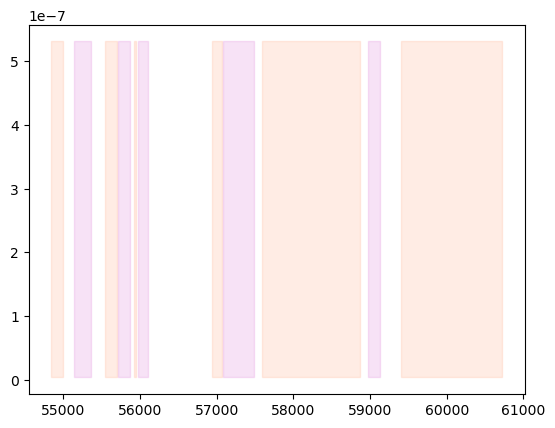

In [9]:
print(sourcelightcurve.name)
sourcelightcurve.plot_hop()
temp = []
othertemp = []
print(len(hops_bl))
for hop in hops_bl:
    print(hop.dur)
    temp.append((hop.dur) / (sourcelightcurve.time[-1] - sourcelightcurve.time[0]))
    othertemp.append(hop.coverage/2)
dcycle = np.sum(temp)
otherdycle = np.sum(othertemp)
print(otherdycle)
print(dcycle)

In [55]:
hops_bl[0].n_bins / (hops_bl[0].end_time - hops_bl[0].start_time)

np.float64(0.14285714285714285)

In [10]:
print(len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']=='4FGL J1337.6-1257']))
np.sum(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']=='4FGL J1337.6-1257']['Coverage'])/2

NameError: name 'COSI_BAND_BAT_weekly_df' is not defined

### Asymmetry

In [139]:
#COSI_BAND_BAT_weekly_df = pd.read_csv('Aug2025_COSI_0.5_(0.1 Counts)_Softer.csv')
#COSI_BAND_BAT_weekly_df = pd.read_csv('COSI+0.5Softer.csv')
asymmetrymatrix = COSI_BAND_BAT_weekly_df[['Asymmetry','Class']]
asymmetrymatrix = asymmetrymatrix[asymmetrymatrix['Asymmetry'] != '0.0']

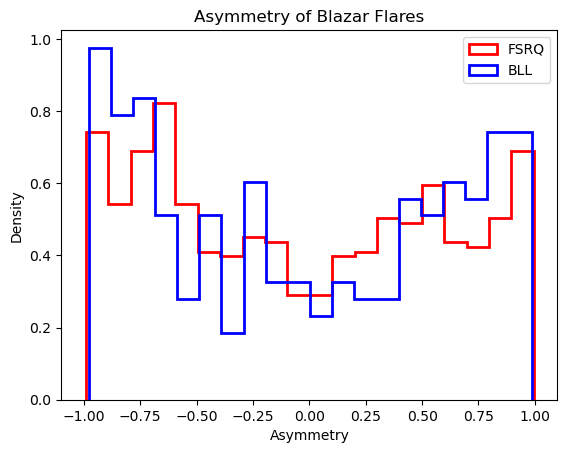

In [140]:
plt.figure()
plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='FSRQ']['Asymmetry'].astype(float),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=2)

plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='BLL']['Asymmetry'].astype(float),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=2)

#plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='BCU']['Asymmetry'].astype(float),label='BCU',bins=20,density=True,histtype='step',color='gray',linewidth=2)

#plt.hist(x=asymmetrymatrix['Asymmetry'].astype(float),label='ALL',bins=20,density=True,histtype='step',color='black',linewidth=2)
plt.xlim(-1.1,1.1)
plt.title('Asymmetry of Blazar Flares')
plt.xlabel('Asymmetry')
plt.ylabel('Density')
plt.legend()


<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_928/2205562540.py:45: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
/tmp/ipykernel_928/2205562540.py:45: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\s

Text(0.5, 1.0, 'Asymmetry of BCU Sources')

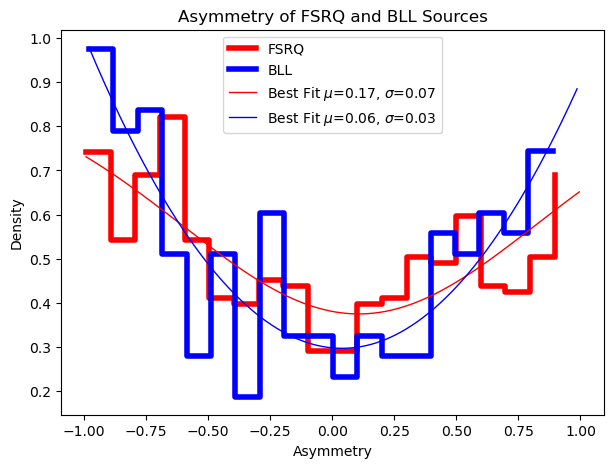

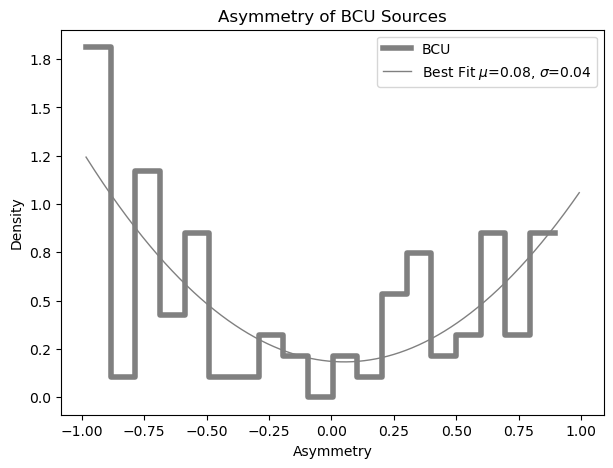

In [141]:
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit

def gaussianfunc(xVar,a,b,c,d):
    return a * np.exp(-(xVar - b) ** 2 / (2 *  c ** 2)) + d


y_fsrq,xe_fsrq=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='FSRQ']['Asymmetry'].astype(float),bins=20,density=True)
x_fsrq = (xe_fsrq[:-1]+xe_fsrq[1:])/2
x_fsrq_refine = np.linspace(xe_fsrq[0],xe_fsrq[-1],1000)
y_bll,xe_bll=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='BLL']['Asymmetry'].astype(float),bins=20,density=True)
x_bll = (xe_bll[:-1]+xe_bll[1:])/2
x_bll_refine = np.linspace(xe_bll[0],xe_bll[-1],1000)
y_bcu,xe_bcu=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='BCU']['Asymmetry'].astype(float),bins=20,density=True)
x_bcu = (xe_bcu[:-1]+xe_bcu[1:])/2
x_bcu_refine = np.linspace(xe_bcu[0],xe_bcu[-1],1000)


gaussfsrq=gaussianfunc(x_fsrq,a=0.1,b=0,c=0.1,d=0)
popt_fsrq, pcov_fsrq = curve_fit(gaussianfunc, x_fsrq, y_fsrq,p0=[0.1,0,0.1,0],maxfev = 10000)
fsrq_mean = 2 * popt_fsrq[1] * np.sqrt(2 / np.pi)
fsrq_std = np.sqrt((popt_fsrq[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussfsrq = gaussianfunc(x_fsrq_refine,popt_fsrq[0],popt_fsrq[1],popt_fsrq[2],popt_fsrq[3])

gaussbll=gaussianfunc(x_bll,a=0.1,b=0,c=0.1,d=0)
popt_bll, pcov_bll = curve_fit(gaussianfunc, x_bll, y_bll,p0=[0.1,0,0.1,0],maxfev = 10000)
bll_mean = 2 * popt_bll[1] * np.sqrt(2 / np.pi)
bll_std = np.sqrt((popt_bll[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussbll=gaussianfunc(x_bll_refine,popt_bll[0],popt_bll[1],popt_bll[2],popt_bll[3])

gaussbcu=gaussianfunc(x_bcu,a=0.1,b=0,c=0.1,d=0)
popt_bcu, pcov_bcu = curve_fit(gaussianfunc, x_bcu, y_bcu,p0=[0.1,0,0.1,0],maxfev = 10000)
bcu_mean = 2 * popt_bcu[1] * np.sqrt(2 / np.pi)
bcu_std = np.sqrt((popt_bcu[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussbcu = gaussianfunc(x_bcu_refine,popt_bcu[0],popt_bcu[1],popt_bcu[2],popt_bcu[3])

fig,ax = plt.subplots(figsize = (7,5))
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float)),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float)),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float)),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)

plt.step(xe_fsrq[:-1],y_fsrq,where='post',color='r',linewidth=4,label='FSRQ')
plt.step(xe_bll[:-1],y_bll,where='post',color='blue',linewidth=4,label='BLL')
#plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4)
plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
plt.plot(x_bll_refine,gaussbll,color='blue',linewidth=1,label=f'Best Fit $\mu$={bll_mean:0.2f}, $\sigma$={bll_std:0.2f}')
#plt.plot(x_bcu_refine,maxbcu,color='grey')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Asymmetry')
plt.title('Asymmetry of FSRQ and BLL Sources')
#plt.savefig('DutyCycles/DutyCycle_FSRQ+BLL_0.5_fit.png')


fig,ax = plt.subplots(figsize = (7,5))
plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4,label='BCU')
plt.plot(x_bcu_refine,gaussbcu,color='grey',linewidth=1,label=f'Best Fit $\mu$={bcu_mean:0.2f}, $\sigma$={bcu_std:0.2f}')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Asymmetry')
plt.title('Asymmetry of BCU Sources')
#plt.savefig('DutyCycles/DutyCycle_BCU_0.5_fit.png')


<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:77: SyntaxWarning: invalid escape sequence '\m'
<>:77: SyntaxWarning: invalid escape sequence '\s'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:77: SyntaxWarning: invalid escape sequence '\m'
<>:77: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_928/1424120370.py:63: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
/tmp/ipykernel_928/1424120370.py:63: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\s

Text(0.5, 1.0, 'Asymmetry of BCU Sources')

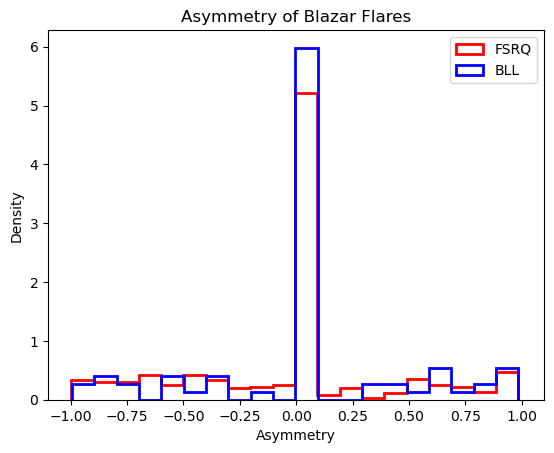

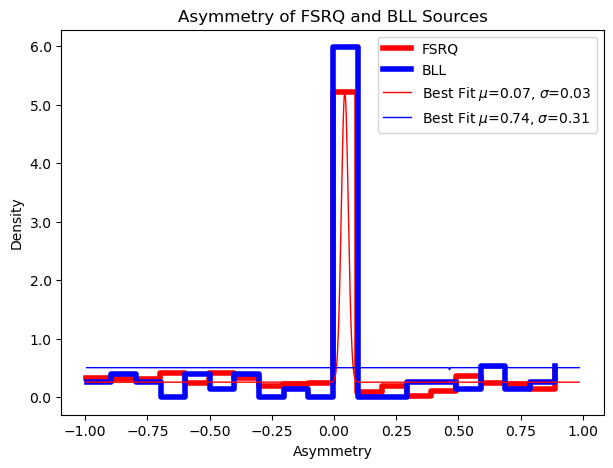

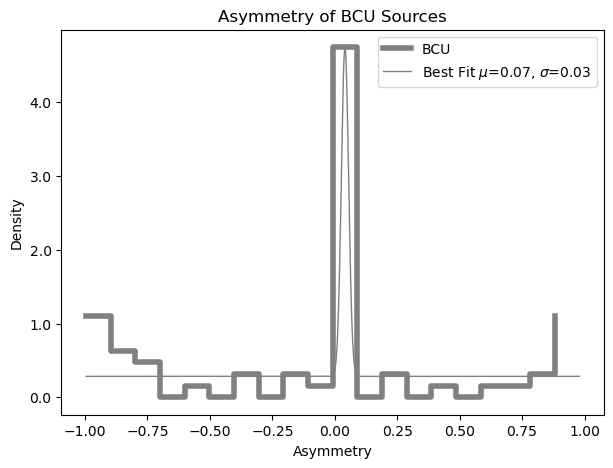

In [142]:
COSI_BAND_BAT_weekly_df2 = pd.read_csv('Aug2025_COSI_0.1_(0.1 Counts).csv')
asymmetrymatrix = COSI_BAND_BAT_weekly_df2[['Asymmetry','Class']]
asymmetrymatrix = asymmetrymatrix[asymmetrymatrix['Asymmetry'] != '0.0']

plt.figure()
plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='FSRQ']['Asymmetry'].astype(float),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=2)

plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='BLL']['Asymmetry'].astype(float),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=2)

#plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='BCU']['Asymmetry'].astype(float),label='BCU',bins=20,density=True,histtype='step',color='gray',linewidth=2)

#plt.hist(x=asymmetrymatrix['Asymmetry'].astype(float),label='ALL',bins=20,density=True,histtype='step',color='black',linewidth=2)
plt.xlim(-1.1,1.1)
plt.title('Asymmetry of Blazar Flares')
plt.xlabel('Asymmetry')
plt.ylabel('Density')
plt.legend()

from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit

def gaussianfunc(xVar,a,b,c,d):
    return a * np.exp(-(xVar - b) ** 2 / (2 *  c ** 2)) + d


y_fsrq,xe_fsrq=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='FSRQ']['Asymmetry'].astype(float),bins=20,density=True)
x_fsrq = (xe_fsrq[:-1]+xe_fsrq[1:])/2
x_fsrq_refine = np.linspace(xe_fsrq[0],xe_fsrq[-1],1000)
y_bll,xe_bll=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='BLL']['Asymmetry'].astype(float),bins=20,density=True)
x_bll = (xe_bll[:-1]+xe_bll[1:])/2
x_bll_refine = np.linspace(xe_bll[0],xe_bll[-1],1000)
y_bcu,xe_bcu=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='BCU']['Asymmetry'].astype(float),bins=20,density=True)
x_bcu = (xe_bcu[:-1]+xe_bcu[1:])/2
x_bcu_refine = np.linspace(xe_bcu[0],xe_bcu[-1],1000)


gaussfsrq=gaussianfunc(x_fsrq,a=0.1,b=0,c=0.1,d=0)
popt_fsrq, pcov_fsrq = curve_fit(gaussianfunc, x_fsrq, y_fsrq,p0=[0.1,0,0.1,0],maxfev = 10000)
fsrq_mean = 2 * popt_fsrq[1] * np.sqrt(2 / np.pi)
fsrq_std = np.sqrt((popt_fsrq[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussfsrq = gaussianfunc(x_fsrq_refine,popt_fsrq[0],popt_fsrq[1],popt_fsrq[2],popt_fsrq[3])

gaussbll=gaussianfunc(x_bll,a=0.1,b=0,c=0.1,d=0)
popt_bll, pcov_bll = curve_fit(gaussianfunc, x_bll, y_bll,p0=[0.1,0,0.1,0],maxfev = 10000)
bll_mean = 2 * popt_bll[1] * np.sqrt(2 / np.pi)
bll_std = np.sqrt((popt_bll[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussbll=gaussianfunc(x_bll_refine,popt_bll[0],popt_bll[1],popt_bll[2],popt_bll[3])

gaussbcu=gaussianfunc(x_bcu,a=0.1,b=0,c=0.1,d=0)
popt_bcu, pcov_bcu = curve_fit(gaussianfunc, x_bcu, y_bcu,p0=[0.1,0,0.1,0],maxfev = 10000)
bcu_mean = 2 * popt_bcu[1] * np.sqrt(2 / np.pi)
bcu_std = np.sqrt((popt_bcu[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussbcu = gaussianfunc(x_bcu_refine,popt_bcu[0],popt_bcu[1],popt_bcu[2],popt_bcu[3])

fig,ax = plt.subplots(figsize = (7,5))
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float)),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float)),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float)),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)

plt.step(xe_fsrq[:-1],y_fsrq,where='post',color='r',linewidth=4,label='FSRQ')
plt.step(xe_bll[:-1],y_bll,where='post',color='blue',linewidth=4,label='BLL')
#plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4)
plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
plt.plot(x_bll_refine,gaussbll,color='blue',linewidth=1,label=f'Best Fit $\mu$={bll_mean:0.2f}, $\sigma$={bll_std:0.2f}')
#plt.plot(x_bcu_refine,maxbcu,color='grey')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Asymmetry')
plt.title('Asymmetry of FSRQ and BLL Sources')
#plt.savefig('DutyCycles/DutyCycle_FSRQ+BLL_0.5_fit.png')


fig,ax = plt.subplots(figsize = (7,5))
plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4,label='BCU')
plt.plot(x_bcu_refine,gaussbcu,color='grey',linewidth=1,label=f'Best Fit $\mu$={bcu_mean:0.2f}, $\sigma$={bcu_std:0.2f}')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Asymmetry')
plt.title('Asymmetry of BCU Sources')
#plt.savefig('DutyCycles/DutyCycle_BCU_0.5_fit.png')



### Lightcurve Illustrations

In [3]:


def maxwellian_function(x, N, a):
    mu = 2*a*(np.sqrt(2/np.pi))
    return N * (x**2*np.exp(-(x - mu)**2/(2*a**2)))/a**3


testnames = ['4FGL J1941.3-6210',
'4FGL J0805.4+6147',
'4FGL J1153.4+4931']

background_ranges = [1]
percent_ranges = [0.5]
table = 'COSICSV/COSI_factors_all_updated_only_logpar_flare_softer_+0.5_updated_60deg_offaxis_last.csv'
for bkg in background_ranges:
    COSI_bkg_rate = bkg * 0.25
    for per in percent_ranges:
        percent = per
        quiescent_background_calc_array = [0,0,0,0,0]
        COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
        flare_array = []
        COSI_BAND_ALL = np.array([0,0,0,0,0,0,0,0,0,0])
        fsrq_names = select_fsrq()['Source_Name']
        bll_names = select_bll()['Source_Name']
        bcu_names = select_bcu()['Source_Name']
        for name in testnames:
            # Grabs the information from the table about each source.
            if name in COSI_LAT_Sources['Name']:
                    
                # Effective Area of Fermi LAT for the source.
                LAT_Aeff = COSI_LAT_Sources[COSI_LAT_Sources['Name']==name]['Aeff_mean_LAT(cm2)']

                # Effective Area of COSI for the source.
                COSI_Aeff = COSI_LAT_Sources[COSI_LAT_Sources['Name']==name]['Aeff_mean_COSI(cm2)']

                # Name of Source
                sourcename = name

                # Conversion factor of counts between Fermi and COSI Bands. (0.1-100 GeV to 0.2-5 MeV)
                ph_ratio = COSI_LAT_Sources[COSI_LAT_Sources['Name']==name]['ph/s_ratio']

                # Conversion factor of flux between Fermi and COSI Bands. (0.1-100 GeV to 0.2-5 MeV)
                flux_ratio = COSI_LAT_Sources[COSI_LAT_Sources['Name']==name]['Int_flux_ratio']

                
                # Grabs data for the source from the cadence_df provided.
                sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
                titlestring=sourcename
                sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
                average_flux = np.nanmean(sourcearray['photon_flux2'])
                sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
                time = sourcearray['tmin']/SecsInDay + MJDREFI
                photon_flux = sourcearray['photon_flux2']
                errors = sourcearray['photon_flux_error2']


                # Creates the lightcurve object of the source.
                sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)

                # Finding the initial flux threshold for detection.
                maxflux = np.max(photon_flux)
                minflux = np.min(photon_flux)
                delta_flux = maxflux - minflux
                delta_flux_percent = delta_flux * percent
                thresholdflux = minflux + delta_flux_percent


                # Initial flare detection.
                sourcelightcurve.get_bblocks(gamma_value=0.05)
                sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)

                # Several failsafes in case no flares are detected or quiescent background cannot be found.
                # These cases will just append -3333 to the final array for that source, and be filtered out.
                # if not sourcelightcurve.hops:
                #     print('no hops found')
                #     characterized_flares = [sourcename,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333]
                #     COSI_BAND = np.array(characterized_flares).T
                #     COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))
                #     continue

                quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward')

                if quiescent_background == np.nan:
                    characterized_flares = [sourcename,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333]
                    COSI_BAND = np.array(characterized_flares).T
                    COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))
                    continue

                # Re-detecting flares with quiescent background.
                sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)

                hops_bl = sourcelightcurve.hops
                # Plotting the Lightcurve itself.
                plt.figure(figsize=(16,9))
                plt.xlabel("MJD")
                plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
                plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
                sourcelightcurve.plot_bblocks(size=2)
                sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Quiescent Bkg',lw=3,linestyle = 'dashed')
                sourcelightcurve.plot_hline(value = thresholdflux, color='red',label='Threshold',lw=3,linestyle = 'dashed')


                y1 = quiescent_background + qui_err
                y2 = quiescent_background - qui_err
                plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

                sourcelightcurve.plot_hop()
                #plotting_anomalies()
                plt.legend()
            else:
                continue




-----------------------------
Selecting FSRQ type blazars
Total number of variable objects: 572
-----------------------------
Selecting BL Lac type blazars
Total number of variable objects: 477
-----------------------------
Selecting unknown type blazars
Total number of variable objects: 364


-----------------------------
Selecting FSRQ type blazars
Total number of variable objects: 572
-----------------------------
Selecting BL Lac type blazars
Total number of variable objects: 477
-----------------------------
Selecting unknown type blazars
Total number of variable objects: 364
841 841 pre creation
0      3.410000e-06
1      2.600000e-06
2      3.010000e-06
3      3.160000e-06
4      2.500000e-06
           ...     
836    5.620000e-07
837    6.670000e-07
838    4.590000e-07
839    6.480000e-07
840    4.820000e-07
Name: photon_flux2, Length: 840, dtype: float64
840 840 post creation
4FGL J2253.9+1609
Quiescent Background: 1.104686113116727e-06, Error: 2.924527426576959e-09


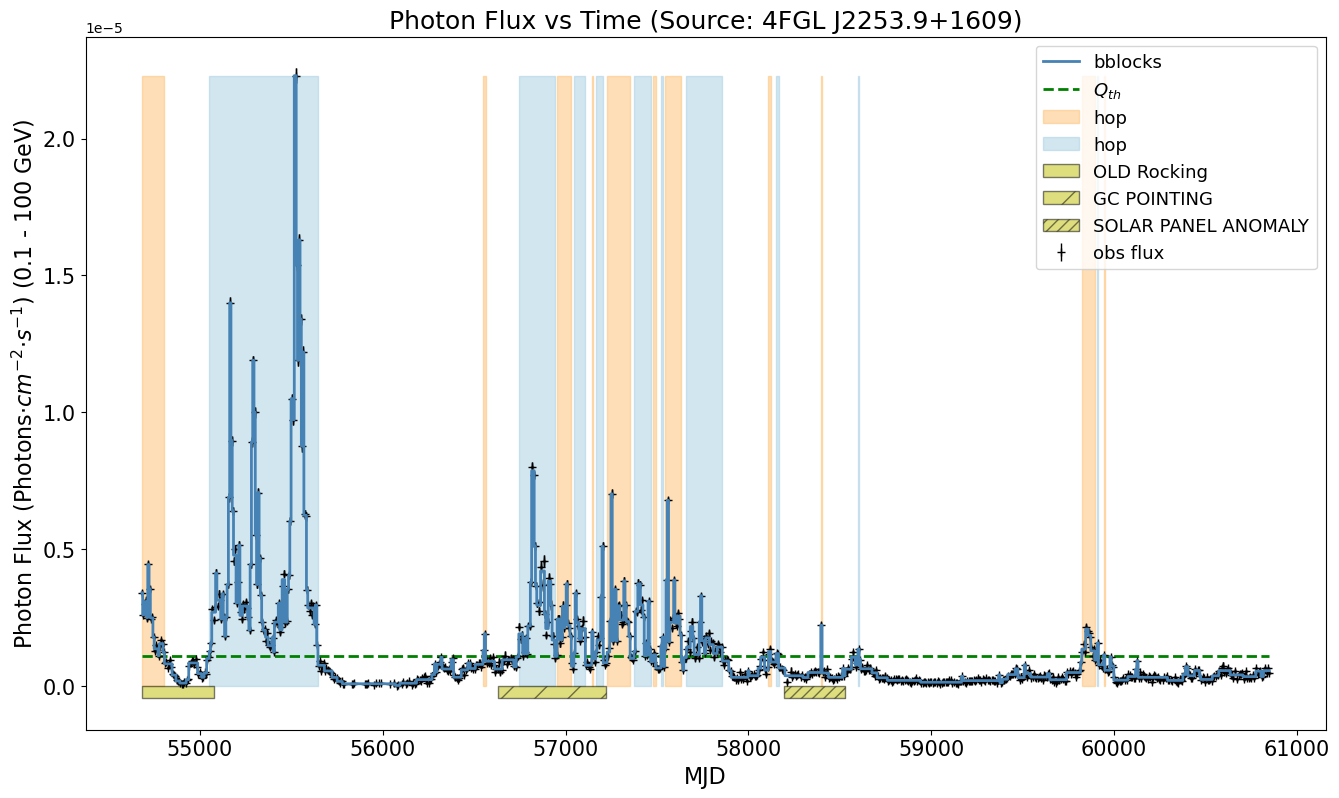

fljgdfkgjdlgkdjklgdg


In [35]:

# ignore_set = set(ignorelist)  # Convert to a set for O(1) average time complexity lookups
# filtered = lightcurveplottingnames
# #filtered = filtered[filtered.isin(ignorelist)]
# filtered = [item for item in filtered if item not in ignore_set]

# BLL_list = pd.read_csv('BLL_names.csv')['Name'].tolist()
testnames = ['4FGL J2253.9+1609']

# testnames = ['4FGL J0001.5+2113']
# testnames = ['4FGL J1153.4+4931']
# testnames = ['4FGL J0116.0-1136']
# percent = 0.3
# COSI_bkg_rate = 1
def maxwellian_function(x, N, a):
        mu = 2*a*(np.sqrt(2/np.pi))
        return N * (x**2*np.exp(-(x - mu)**2/(2*a**2)))/a**3
### HOly crap time to test to see if we should use sharp...
background_ranges = [0.1]
percent_ranges = [0.5]
table = 'COSICSV/COSI_factors_all_updated_only_logpar_flare_updated_60deg_offaxis_last.csv'
for bkg in background_ranges:
        COSI_bkg_rate = bkg * 0.25
        for per in percent_ranges:
                percent = per
                quiescent_background_calc_array = [0,0,0,0,0]
                COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
                flare_array = []
                COSI_BAND_ALL = np.array([0,0,0,0,0,0,0,0,0,0,0])
                fsrq_names = select_fsrq()['Source_Name']
                bll_names = select_bll()['Source_Name']
                bcu_names = select_bcu()['Source_Name']
                for i,name in enumerate(testnames):
                        # Grabs the information from the table about each source.

                        # Effective Area of Fermi LAT for the source.
                        LAT_Aeff = COSI_LAT_Sources[COSI_LAT_Sources['Name']==name]['Aeff_mean_LAT(cm2)']

                        # Effective Area of COSI for the source.
                        COSI_Aeff = COSI_LAT_Sources[COSI_LAT_Sources['Name']==name]['Aeff_mean_COSI(cm2)']

                        # Name of Source
                        sourcename = name
                        # if sourcename in ignorelist:
                        #         continue

                        # Conversion factor of counts between Fermi and COSI Bands. (0.1-100 GeV to 0.2-5 MeV)
                        ph_ratio = COSI_LAT_Sources[COSI_LAT_Sources['Name']==name]['ph/s_ratio']

                        # Conversion factor of flux between Fermi and COSI Bands. (0.1-100 GeV to 0.2-5 MeV)
                        flux_ratio = COSI_LAT_Sources[COSI_LAT_Sources['Name']==name]['Int_flux_ratio']

                        
                        # Grabs data for the source from the cadence_df provided.
                        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
                        titlestring=sourcename
                        #sourcearray = sourcearray[600:680]
                        sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
                        average_flux = np.nanmean(sourcearray['photon_flux2'])
                        sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
                        print(len(sourcearray['tmin']),len(sourcearray['photon_flux2']),'pre creation')
                        time = sourcearray['tmin']/SecsInDay + MJDREFI
                        #time = sourcearray['tmin']/SecsInDay
                        photon_flux = sourcearray['photon_flux2']
                        errors = sourcearray['photon_flux_error2']
                        if sourcename == '4FGL J1941.3-6210':
                                badtimes = [58309.00001157408,58526.00001157408,58680.00001157408,59051.00001157408,59422.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        if sourcename == '4FGL J0805.4+6147':
                                badtimes = [59576.00001157408,59947.00001157408,60472.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        if sourcename == '4FGL J1153.4+4931':
                                badtimes = [58785.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        if sourcename == '4FGL J0116.0-1136':
                                badtimes = [58239.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        if sourcename == '4FGL J0102.8+5824':
                                badtimes = [60227.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        if sourcename == '4FGL J0359.6+5057':
                                badtimes = [58638.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        if sourcename == '4FGL J0533.3+4823':
                                badtimes = [58260.00001157408,59002.00001157408,59744.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        if sourcename == '4FGL J0533.3+4823':
                                badtimes = [58260.00001157408,59002.00001157408,59744.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        if sourcename == '4FGL J0534.5+2201s':
                                badtimes = [59744.00001157408,60115.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        if sourcename == '4FGL J0622.9+3326':
                                badtimes = [60479.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        if sourcename == '4FGL J1535.8-4730':
                                badtimes = [58792.00001157408,59163.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        if sourcename == '4FGL J1555.2-4149':
                                badtimes = [58421.00001157408,59163.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        if sourcename == '4FGL J1941.3-6210':
                                badtimes = [59793.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        if sourcename == '4FGL J2253.9+1609':
                                badtimes = [55516.00001157408]#,55523.00001157408,55544.00001157408,55530.00001157408,55166.00001157408,55551.00001157408]
                                mask = ~np.isin(time,badtimes)
                                time = time[mask]
                                photon_flux = photon_flux[mask]
                                errors = errors[mask]
                        
                        print(photon_flux)
                        print(len(time),len(photon_flux),'post creation')


                        # Creates the lightcurve object of the source.
                        sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)

                        # Finding the initial flux threshold for detection.
                        maxflux = np.max(photon_flux)
                        minflux = np.min(photon_flux)
                        delta_flux = maxflux - minflux
                        delta_flux_percent = delta_flux * percent
                        thresholdflux = minflux + delta_flux_percent


                        # Initial flare detection.
                        print(sourcename)
                        sourcelightcurve.get_bblocks(gamma_value=0.05)
                        sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)

                        # Several failsafes in case no flares are detected or quiescent background cannot be found.
                        # These cases will just append -3333 to the final array for that source, and be filtered out.
                        # if not sourcelightcurve.hops:
                        #     print('no hops found')
                        #     characterized_flares = [sourcename,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333]
                        #     COSI_BAND = np.array(characterized_flares).T
                        #     COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))
                        #     continue

                        quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward')
                        #quiescent_background = thresholdflux
                        if quiescent_background == np.nan:
                                characterized_flares = [sourcename,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333]
                                COSI_BAND = np.array(characterized_flares).T
                                COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))
                        

                        # # Re-detecting flares with quiescent background.
                        sourcelightcurve = LC.LightCurve(time,photon_flux,errors,name=titlestring)
                        sourcelightcurve.get_bblocks(gamma_value=0.05)
                        sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)

                        # Plotting the Lightcurve itself.
                        plt.figure(figsize=(16,9))
                        plt.xlabel("MJD",fontsize=16)
                        plt.ylabel('Photon Flux (Photons\u22c5$cm^{-2}\u22c5s^{-1}$) (0.1 - 100 GeV)',fontsize=16)
                        plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')',fontsize=18 )
                        sourcelightcurve.plot_lc()
                        try:
                                sourcelightcurve.get_bblocks(gamma_value=0.05)
                                sourcelightcurve.plot_bblocks(size=2)
                        except:
                                print('no bb :(')
                        sourcelightcurve.plot_hline(value = quiescent_background, color='green',label=r'$Q_{th}$',lw=2,linestyle = 'dashed')
                        #sourcelightcurve.plot_hline(value = thresholdflux, color='red',label=r'$F_{th}$',lw=2,linestyle = 'dashed')


                        #y1 = quiescent_background + qui_err
                        #y2 = quiescent_background - qui_err
                        #plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

                        sourcelightcurve.plot_hop()
                        plotting_anomalies()
                        #plt.locator_params(axis='x', nbins=6)
                        # make ticks and labels bigger
                        plt.xticks(fontsize=15)
                        plt.yticks(fontsize=15)
                        plt.legend(loc='upper right', fontsize=13)
                        #plt.savefig('RemadeNov2025/LightcurvePlots/Below100Updated/' + sourcename + '.png', dpi=200, bbox_inches='tight')
                        plt.show()
                        #plt.close()
                else:
                        print('fljgdfkgjdlgkdjklgdg')

(np.float64(55565.00001157408), np.float64(1.22e-05))

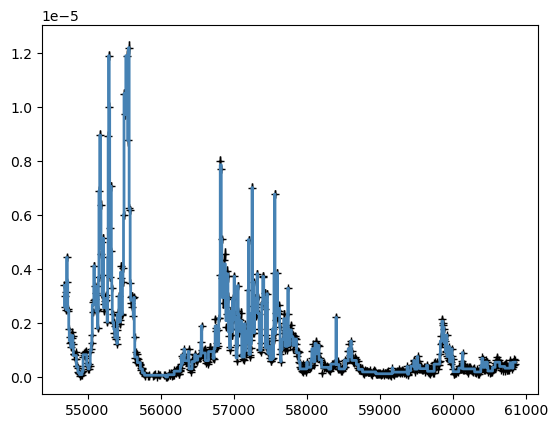

In [29]:
hops_bl = sourcelightcurve.hops
plotit = sourcelightcurve#.select_by_time(hops_bl[7].start_time,hops_bl[7].end_time)
plotit.plot_lc()
plotit.get_bblocks(gamma_value=0.05)
plotit.plot_bblocks(size=2)
argmax = np.argmax(plotit.flux)
plotit.time[argmax], plotit.flux[argmax]
# 58260.00001157408,59002.00001157408

In [31]:
COSI_BAND_BAT_weekly_df = pd.read_csv('RemadeNov2025/November2025_COSI_Eta0.5_bkg0.10softer0.5.csv')
# ignorelist = ['4FGL J0010.6+2043',
# '4FGL J0222.0-1616',
# '4FGL J0228.0-3026',
# '4FGL J0312.8+0134',
# '4FGL J0358.9+6004',
# '4FGL J0824.7+5552',
# '4FGL J1031.6+6019',
# '4FGL J1209.8+1810',
# '4FGL J1446.7+1719',
# '4FGL J1635.6+3628',
# '4FGL J1647.5+4950',
# '4FGL J1716.1+6836',
# '4FGL J1724.9+7654',
# '4FGL J1808.1-5013',
# '4FGL J2256.0-2740',
# '4FGL J1222.5+0414',
# '4FGL J0405.6-1308',
# '4FGL J0336.4+3224',
# '4FGL J1337.6-1257',
# '4FGL J1924.8-2914',
# '4FGL J0024.7+0349',
# '4FGL J0239.7+0415',
# '4FGL J0904.6+5200',
# '4FGL J1118.2-0415',
# '4FGL J1205.7-2635',
# '4FGL J1324.9+4748',
# '4FGL J1445.9-1626',
# '4FGL J1559.9+2319',
# '4FGL J1650.3-5045']

# ignorelist = ['4FGL J0010.6+2043',
# '4FGL J0222.0-1616',
# '4FGL J0228.0-3026',
# '4FGL J0312.8+0134',
# '4FGL J0358.9+6004',
# '4FGL J0824.7+5552',
# '4FGL J1031.6+6019',
# '4FGL J1209.8+1810',
# '4FGL J1446.7+1719',
# '4FGL J1635.6+3628',
# '4FGL J1647.5+4950',
# '4FGL J1716.1+6836',
# '4FGL J1724.9+7654',
# '4FGL J1808.1-5013',
# '4FGL J2256.0-2740',
# '4FGL J1222.5+0414',
# '4FGL J0405.6-1308',
# '4FGL J0336.4+3224',
# '4FGL J1337.6-1257',
# '4FGL J1924.8-2914',
# '4FGL J0024.7+0349',
# '4FGL J0239.7+0415',
# '4FGL J0904.6+5200',
# '4FGL J1118.2-0415',
# '4FGL J1205.7-2635',
# '4FGL J1324.9+4748',
# '4FGL J1445.9-1626',
# '4FGL J1559.9+2319',
# '4FGL J1650.3-5045']
# ignore_set = set(ignorelist)  # Convert to a set for O(1) average time complexity lookups
# filtered = lightcurveplottingnames
# #filtered = filtered[filtered.isin(ignorelist)]
# filtered = [item for item in filtered if item not in ignore_set]

filtered100 = COSI_BAND_BAT_weekly_df
filtered100 = filtered100[filtered100['MDP99_(%)']<100].reset_index(drop=True)
filtered100 = filtered100[['Name','Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)','Average_Flux_of_Entire_Source_(0.2-5_MeV)','Start_Time_(MJD)']].reset_index(drop=True)
filtered100['Name'].drop_duplicates()
filtered = filtered100['Name'].drop_duplicates()
filtered = filtered.reset_index(drop=True)

filtered100.to_csv('RemadeNov2025/LightcurvePlots/Below100Updated/COSI_Flare_Sources_Flux_Start_Time.csv')

In [31]:
badtimes = [58309.00001157408,58526.00001157408,58680.00001157408,59051.00001157408,59422.00001157408]
mask = ~np.isin(time,badtimes)
time = time[mask]
photon_flux = photon_flux[mask]
errors = errors[mask]

np.float64(55523.00001157408)

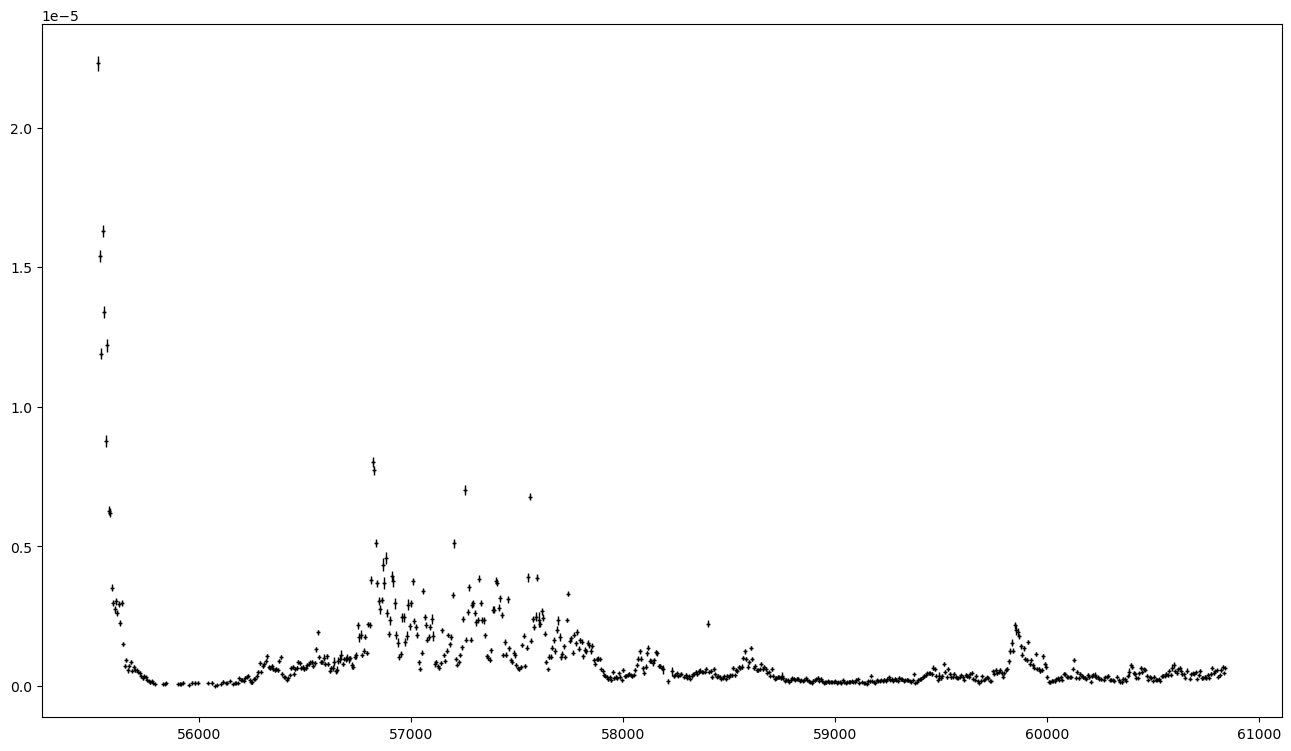

In [46]:
plt.figure(figsize=(16,9))

#sourcelightcurve.plot_lc()
smallerlc = sourcelightcurve.select_by_time(55517,sourcelightcurve.time[-1])
smallerlc.plot_lc()
np.argmax(smallerlc.flux)
smallerlc.time[np.argmax(smallerlc.flux)]

#55516.00001157408
#cuttimes = [58309.00001157408,58526.00001157408,58680.00001157408,59051.00001157408,59422.00001157408]



In [48]:
ignorelist = ['4FGL J0116.0-1136','4FGL J0200.6-6637','4FGL J0224.9+1843','4FGL J0304.5+3349','4FGL J0347.7-3616',
'4FGL J0427.3-3900','4FGL J0450.3-4419','4FGL J0617.6-4028','4FGL J0746.4+2546','4FGL J0805.4+6147','4FGL J0943.7+6137',
'4FGL J1043.2+2408','4FGL J1200.7+2008','4FGL J1659.7-3131','4FGL J1747.6-5308','4FGL J1824.5+0107','4FGL J1912.1-0803',
'4FGL J2040.5-1705','4FGL J2120.6-1254','4FGL J2148.6+0652','4FGL J2149.7+1917','4FGL J2207.6+0053','4FGL J2358.0-4601',
'4FGL J0024.7+0349','4FGL J0239.7+0415','4FGL J0904.6+5200','4FGL J1118.2-0415','4FGL J1205.7-2635','4FGL J1324.9+4748',
'4FGL J1445.9-1626','4FGL J1559.9+2319','4FGL J1650.3-5045','4FGL J1941.3-6210','4FGL J0805.4+6147','4FGL J1153.4+4931',
'4FGL J0010.6+2043','4FGL J0222.0-1616','4FGL J0228.0-3026','4FGL J0312.8+0134','4FGL J0358.9+6004','4FGL J0824.7+5552',
'4FGL J1031.6+6019','4FGL J1209.8+1810','4FGL J1446.7+1719','4FGL J1635.6+3628','4FGL J1647.5+4950','4FGL J1716.1+6836',
'4FGL J1724.9+7654','4FGL J1808.1-5013','4FGL J2256.0-2740','4FGL J0405.6-1308','4FGL J0336.4+3224',
'4FGL J1337.6-1257','4FGL J1924.8-2914',
'4FGL J0433.0+0522','4FGL J0522.9-3628','4FGL J0324.8+3412']
weeklydf = pd.read_csv('RemadeNov2025/November2025_COSI_Eta0.5_bkg20.00softer0.5.csv')
print(len(weeklydf['Name'].drop_duplicates()))
weeklydf = weeklydf[~weeklydf['Name'].isin(ignorelist)].reset_index(drop=True)
print(len(weeklydf['Name'].drop_duplicates()))
weeklydf = weeklydf[weeklydf['MDP99_(%)']<20].reset_index(drop=True)
weeklydf = weeklydf[weeklydf['Duration_(s)']<7*24*3600*8].reset_index(drop=True)
print(len(weeklydf['Name'].drop_duplicates()))
print(len(weeklydf['Name']))

1402
1347


In [54]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0.0  # Handle empty sets
    return (intersection / union) * 100

# list1 = ['4FGL J0010.6+2043','4FGL J0222.0-1616','4FGL J0228.0-3026','4FGL J0312.8+0134',
# '4FGL J0358.9+6004','4FGL J0824.7+5552','4FGL J1031.6+6019','4FGL J1209.8+1810','4FGL J1446.7+1719','4FGL J1635.6+3628',
# '4FGL J1647.5+4950','4FGL J1716.1+6836','4FGL J1724.9+7654','4FGL J1808.1-5013','4FGL J2256.0-2740','4FGL J1222.5+0414',
# '4FGL J0405.6-1308','4FGL J0336.4+3224','4FGL J1337.6-1257','4FGL J1924.8-2914','4FGL J0024.7+0349','4FGL J0239.7+0415',
# '4FGL J0904.6+5200','4FGL J1118.2-0415','4FGL J1205.7-2635','4FGL J1324.9+4748','4FGL J1445.9-1626','4FGL J1559.9+2319',
# '4FGL J1650.3-5045','4FGL J0116.0-1136','4FGL J0200.6-6637','4FGL J0224.9+1843','4FGL J0304.5+3349','4FGL J0347.7-3616',
# '4FGL J0427.3-3900','4FGL J0450.3-4419','4FGL J0617.6-4028','4FGL J0746.4+2546','4FGL J0805.4+6147','4FGL J0943.7+6137',
# '4FGL J1043.2+2408','4FGL J1200.7+2008','4FGL J1659.7-3131','4FGL J1747.6-5308','4FGL J1824.5+0107','4FGL J1912.1-0803',
# '4FGL J2040.5-1705','4FGL J2120.6-1254','4FGL J2148.6+0652','4FGL J2149.7+1917','4FGL J2207.6+0053','4FGL J2358.0-4601']
# list2 = ['4FGL J0116.0-1136','4FGL J0200.6-6637','4FGL J0224.9+1843','4FGL J0304.5+3349','4FGL J0347.7-3616',
# '4FGL J0427.3-3900','4FGL J0450.3-4419','4FGL J0617.6-4028','4FGL J0746.4+2546','4FGL J0805.4+6147','4FGL J0943.7+6137',
# '4FGL J1043.2+2408','4FGL J1200.7+2008','4FGL J1659.7-3131','4FGL J1747.6-5308','4FGL J1824.5+0107','4FGL J1912.1-0803',
# '4FGL J2040.5-1705','4FGL J2120.6-1254','4FGL J2148.6+0652','4FGL J2149.7+1917','4FGL J2207.6+0053','4FGL J2358.0-4601',
# '4FGL J0024.7+0349','4FGL J0239.7+0415','4FGL J0904.6+5200','4FGL J1118.2-0415','4FGL J1205.7-2635','4FGL J1324.9+4748',
# '4FGL J1445.9-1626','4FGL J1559.9+2319','4FGL J1650.3-5045','4FGL J1941.3-6210','4FGL J0805.4+6147','4FGL J1153.4+4931',
# '4FGL J0010.6+2043','4FGL J0222.0-1616','4FGL J0228.0-3026','4FGL J0312.8+0134','4FGL J0358.9+6004','4FGL J0824.7+5552',
# '4FGL J1031.6+6019','4FGL J1209.8+1810','4FGL J1446.7+1719','4FGL J1635.6+3628','4FGL J1647.5+4950','4FGL J1716.1+6836',
# '4FGL J1724.9+7654','4FGL J1808.1-5013','4FGL J2256.0-2740','4FGL J0405.6-1308','4FGL J0336.4+3224',
# '4FGL J1337.6-1257','4FGL J1924.8-2914',
# '4FGL J0433.0+0522','4FGL J0522.9-3628','4FGL J0324.8+3412']

similarity_percentage = jaccard_similarity(ignorelist, ignorelist2)
print(f"Similarity Percentage: {similarity_percentage:.2f}%") # Output: Similarity Percentage: 33.33%

Similarity Percentage: 0.00%


### Brightest Flares

In [167]:
brightest_flares = pd.read_csv('RemadeNov2025/November2025_COSI_Eta0.3_bkg1.00.csv')
brightest_flares = brightest_flares[brightest_flares['Class']!='-3333'].reset_index(drop=True)
brightest_flares = brightest_flares[brightest_flares['Class']!=np.nan]
brightest_flares = brightest_flares[brightest_flares['MDP99_(%)']<=50]
brightest_flares = brightest_flares[brightest_flares['Duration_(s)']<=8*7*86400]
brightest_flares['Duration_(s)'] = brightest_flares['Duration_(s)']/(86400*7)
brightest_flares = brightest_flares.sort_values('MDP99_(%)',ascending = True).reset_index(drop=True)
brightest_flares['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'] = brightest_flares['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)']*1000
brightest_flares['Peak_Flare_Flux_(0.2-5_MeV)'] = brightest_flares['Peak_Flare_Flux_(0.2-5_MeV)']*1000
print(brightest_flares.loc[:,['Name','Class','MDP99_(%)','Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)', 'Peak_Flare_Flux_(0.2-5_MeV)','Duration_(s)']].to_latex(index=False,formatters={"Name":str.upper},float_format="{:.4}".format))

\begin{tabular}{llrrrr}
\toprule
Name & Class & MDP99_(%) & Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV) & Peak_Flare_Flux_(0.2-5_MeV) & Duration_(s) \\
\midrule
4FGL J1229.0+0202 & FSRQ & 17.69 & 1.411 & 2.491 & 8.0 \\
4FGL J1229.0+0202 & FSRQ & 21.23 & 1.49 & 2.017 & 5.0 \\
4FGL J1229.0+0202 & FSRQ & 21.26 & 1.25 & 1.617 & 7.0 \\
4FGL J1229.0+0202 & FSRQ & 21.62 & 2.363 & 2.363 & 2.0 \\
4FGL J1229.0+0202 & FSRQ & 21.73 & 2.739 & 2.739 & 1.5 \\
4FGL J1229.0+0202 & FSRQ & 22.31 & 2.664 & 2.664 & 1.5 \\
4FGL J1229.0+0202 & FSRQ & 23.22 & 1.065 & 1.356 & 8.0 \\
4FGL J2253.9+1609 & FSRQ & 23.89 & 1.067 & 1.421 & 8.0 \\
4FGL J1229.0+0202 & FSRQ & 24.2 & 1.021 & 1.523 & 8.0 \\
4FGL J0539.9-2839 & FSRQ & 26.93 & 1.322 & 1.975 & 4.0 \\
4FGL J1229.0+0202 & FSRQ & 27.2 & 1.502 & 1.717 & 3.0 \\
4FGL J1229.0+0202 & FSRQ & 27.78 & 1.469 & 1.811 & 3.0 \\
4FGL J1229.0+0202 & FSRQ & 28.39 & 0.8669 & 0.9859 & 8.0 \\
4FGL J1229.0+0202 & FSRQ & 29.39 & 1.065 & 1.42 & 5.0 \\
4FGL J1229.0+0202 & FSRQ & 30.1

In [165]:
brightest_sources = pd.read_csv('RemadeNov2025/November2025_COSI_Eta0.3_bkg1.00.csv')
# brightest_sources = brightest_sources[brightest_sources['Class']!='FSRQ']
# brightest_sources = brightest_sources[brightest_sources['Class']!='BLL']
# brightest_sources = brightest_sources[brightest_sources['Class']!='BCU']
brightest_sources = brightest_sources[brightest_sources['Class']!='-3333'].reset_index(drop=True)
brightest_sources.drop_duplicates(subset=['Name']).reset_index(drop=True)
brightest_sources = brightest_sources[brightest_sources['MDP99_(%)']<=50]
brightest_sources = brightest_sources[brightest_sources['Duration_(s)']<=8*7*86400]
brightest_sources = brightest_sources.sort_values('MDP99_(%)',ascending = True).drop_duplicates(subset=['Name']).reset_index(drop=True)
brightest_sources.loc[:,['Name','Class','MDP99_(%)','Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)', 'Peak_Flare_Flux_(0.2-5_MeV)','Duration_(s)','Start_Time_(MJD)']]
brightest_sources['Duration_(s)'] = brightest_sources['Duration_(s)']/(86400*7)
brightest_sources = brightest_sources.sort_values('MDP99_(%)',ascending = True).reset_index(drop=True)
brightest_sources['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)'] = brightest_sources['Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)']*1000
brightest_sources['Peak_Flare_Flux_(0.2-5_MeV)'] = brightest_sources['Peak_Flare_Flux_(0.2-5_MeV)']*1000
print(brightest_sources.loc[:,['Name','Class','MDP99_(%)','Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV)', 'Peak_Flare_Flux_(0.2-5_MeV)','Duration_(s)']].to_latex(index=False,formatters={"Name":str.upper},float_format="{:.4}".format))
# plottingnames = brightest_sources['Name'].to_list()
# plottingnames

\begin{tabular}{llrrrr}
\toprule
Name & Class & MDP99_(%) & Average_Photon_Flux_(ph/cm2/s)_(0.2-5_MeV) & Peak_Flare_Flux_(0.2-5_MeV) & Duration_(s) \\
\midrule
4FGL J1229.0+0202 & FSRQ & 17.69 & 1.411 & 2.491 & 8.0 \\
4FGL J2253.9+1609 & FSRQ & 23.89 & 1.067 & 1.421 & 8.0 \\
4FGL J0539.9-2839 & FSRQ & 26.93 & 1.322 & 1.975 & 4.0 \\
4FGL J1256.1-0547 & FSRQ & 37.49 & 0.7877 & 1.699 & 6.0 \\
4FGL J2151.8-3027 & FSRQ & 40.69 & 0.865 & 0.9141 & 4.0 \\
4FGL J1129.8-1447 & FSRQ & 43.8 & 1.134 & 1.623 & 2.0 \\
4FGL J1512.8-0906 & FSRQ & 46.74 & 0.6268 & 1.232 & 6.0 \\
\bottomrule
\end{tabular}



In [138]:
f = ['RemadeNov2025/November2025_COSI_Eta0.1_bkg1.00.csv','RemadeNov2025/November2025_COSI_Eta0.1_bkg5.00.csv',
    'RemadeNov2025/November2025_COSI_Eta0.1_bkg10.00.csv','RemadeNov2025/November2025_COSI_Eta0.1_bkg20.00.csv',
    'RemadeNov2025/November2025_COSI_Eta0.3_bkg1.00.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg5.00.csv',
    'RemadeNov2025/November2025_COSI_Eta0.3_bkg10.00.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg20.00.csv',
    'RemadeNov2025/November2025_COSI_Eta0.5_bkg1.00.csv','RemadeNov2025/November2025_COSI_Eta0.5_bkg5.00.csv',
    'RemadeNov2025/November2025_COSI_Eta0.5_bkg10.00.csv','RemadeNov2025/November2025_COSI_Eta0.5_bkg20.00.csv',
    'RemadeNov2025/November2025_COSI_Eta0.1_bkg0.10.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg0.10.csv',
    'RemadeNov2025/November2025_COSI_Eta0.5_bkg0.10.csv']
# f = ['RemadeNov2025/November2025_COSI_Eta0.1_bkg1.00softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.1_bkg5.00softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.1_bkg10.00softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.1_bkg20.00softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.3_bkg1.00softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg5.00softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.3_bkg10.00softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg20.00softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.5_bkg1.00softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.5_bkg5.00softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.5_bkg10.00softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.5_bkg20.00softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.1_bkg0.10softer0.5.csv','RemadeNov2025/November2025_COSI_Eta0.3_bkg0.10softer0.5.csv',
#      'RemadeNov2025/November2025_COSI_Eta0.5_bkg0.10softer0.5.csv']
for i in range(len(f)):
    COSI_BAND_BAT_weekly_df = pd.read_csv(f[i], sep=",", na_filter=True)
    COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[~COSI_BAND_BAT_weekly_df['Name'].isin(ignorelist)].reset_index(drop=True)
    COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df.dropna()
    COSI_BAND_BAT_weekly_df.to_csv(f[i])
# print(len(brightest_sources.drop_duplicates(subset=['Name'])['Name'].reset_index(drop=True)))

In [10]:
duration = 5*24*7*3600
mohammad_S = 128769
mohammad_B = 67177721
mohammad_S_rate = mohammad_S / duration
mohammad_B_rate = mohammad_B / duration
garrett_S = 60865
garrett_B = 16632000
garrett_S_rate = garrett_S / duration
garrett_B_rate = garrett_B / duration
duration = 5*24*7*3600*0.25
print(mohammad_B_rate,garrett_B_rate)

garrett_MDP = ComputeMDP99(garrett_S, garrett_B)
print(garrett_MDP)
mohammad_MDP = ComputeMDP99(mohammad_S, mohammad_B)
print(mohammad_MDP)

uncertainty_garrett = [np.sqrt(garrett_S), np.sqrt(garrett_B)]
uncertainty_mohammad = [np.sqrt(mohammad_S), np.sqrt(mohammad_B)]


22.214854828042327 5.5
95.99173727404585
91.10730199918096


In [15]:
def MDP99_uncertainty(S,B,mu=0.3):
    delta_S = np.sqrt(S)
    delta_B = np.sqrt(B)
    term1 = ((-(S+2*B)*4.29*100)/(2*S**2*np.sqrt(S+B)*mu)*delta_S)**2
    term2 = ((4.29*100/(2*mu*S*np.sqrt(S+B)))*delta_B)**2
    delta_MDP99 = np.sqrt(term1 + term2)
    return delta_MDP99

MDP99_uncertainty_garrett = MDP99_uncertainty(garrett_S, garrett_B)
MDP99_uncertainty_mohammad = MDP99_uncertainty(mohammad_S, mohammad_B)
print('Garrett MDP99 is ', garrett_MDP, '+/-', MDP99_uncertainty_garrett)
print('Mohammad MDP99 is ', mohammad_MDP, '+/-', MDP99_uncertainty_mohammad)

Garrett MDP99 is  95.99173727404585 +/- 0.3885576004719291
Mohammad MDP99 is  91.10730199918096 +/- 0.2537089104956525


In [22]:
print(garrett_S)
print(garrett_B)
print('')
print(mohammad_S)
print(mohammad_B)

60865
16632000

128769
67177721
